# Predicción de Incapacidad Laboral - Regresión 2 (Statsmodels)

## 1 Conexión Google Drive y definición de paths

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
path_bronze_histplantas = '/content/gdrive/MyDrive/Trabajo_grado_maestria/Bronze/histplantas'
path_bronze_jerarquiasareashist = '/content/gdrive/MyDrive/Trabajo_grado_maestria/Bronze/jerarquias_areas_hist'

## 2 Cargue y lectura de datasets

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Convirtiendo en dataframe cada archivo de cada mes del dataset histplantas
dfs = []

for filename in os.listdir(path_bronze_histplantas):
   df = pd.read_excel(os.path.join(path_bronze_histplantas, filename), header=0)
   dfs.append(df)

print(len(dfs))

13


In [ ]:
pd.options.display.max_columns = None
dfs[12]

In [ ]:
# Unificando los meses en un solo dataset de histplantas
df_histplantas = dfs[0]
for i in range(1, len(dfs)):
    df_histplantas = df_histplantas._append(dfs[i])

In [ ]:
df_histplantas.shape

(173721, 39)

In [ ]:
df_histplantas.head()

In [ ]:
# Dejando el dataset solo con las variables que nos interesan
variables_histplantas = ['numero','CEDULA', 'CARGO', 'codarea', 'cargoSap']
df_histplantas = df_histplantas[variables_histplantas]

In [ ]:
df_histplantas.shape

(173721, 5)

In [ ]:
df_histplantas.head()

In [ ]:
# Convirtiendo en dataframe cada archivo de cada mes del dataset jerarquiasareashist
dfs1 = []

for filename in os.listdir(path_bronze_jerarquiasareashist):
   df = pd.read_excel(os.path.join(path_bronze_jerarquiasareashist, filename), header=0)
   dfs1.append(df)

print(len(dfs1))

24


In [ ]:
dfs1[23]

In [ ]:
# Unificando los meses en un solo dataset de jerarquiasareashist
df_jerarquiasareashist = dfs1[0]
for i in range(1, len(dfs1)):
    df_jerarquiasareashist = df_jerarquiasareashist._append(dfs1[i])

In [ ]:
df_jerarquiasareashist.shape

(82228, 66)

In [ ]:
df_jerarquiasareashist.head()

In [ ]:
# Dejando el dataset solo con las variables que nos interesan
variables_jerarquiasareashist = ['Id_ficticio','name_area','niveljer', 'estado', 'periodo', 'nivel1', 'nivel2', 'nivel3', 'nivel4', 'nivel5', 'nivel6', 'nivel7', 'nivel8', 'nivel9', 'nivel10', 'nivel11', 'aplica_ci']
df_jerarquiasareashist = df_jerarquiasareashist[variables_jerarquiasareashist]

In [ ]:
df_jerarquiasareashist.shape

(82228, 17)

In [ ]:
df_jerarquiasareashist.head(20)

In [ ]:
#Se eliminan registros vacíos
df_jerarquiasareashist = df_jerarquiasareashist.dropna(axis = 0, how = 'all')

In [ ]:
df_jerarquiasareashist.head(20)

In [ ]:
df_jerarquiasareashist.shape

(63504, 17)

In [ ]:
#Se carga y convierte a dataframe la tabla Indipersonas
df_indipersonas = pd.read_excel("gdrive/MyDrive/Trabajo_grado_maestria/Bronze/indi_personas/Indi_Personas202201-202312.xlsx", header=0)

In [ ]:
df_indipersonas.shape

(168079, 20)

In [ ]:
df_indipersonas.head(20)

In [ ]:
#Se retiran las columnas que no se necesitan
df_indipersonas = df_indipersonas.drop(columns = ['NOMBRE','codarea2', 'minutos_lab_mes', 'minutos_ajustados'])

In [ ]:
df_indipersonas.shape

(168079, 16)

In [ ]:
df_indipersonas.head()

In [ ]:
#Se carga y convierte a dataframe la tabla Ausencias
df_ausencias = pd.read_excel("gdrive/MyDrive/Trabajo_grado_maestria/Bronze/reporte_ausencia/Reporte_ausencia.xlsx", header=0)

In [ ]:
df_ausencias.shape

(191227, 13)

In [ ]:
df_ausencias.head()

In [ ]:
#Se eliminan las columnas que no se requieren
df_ausencias = df_ausencias.drop(columns = ['#', 'AutoAus', 'idAjuste', 'MinutosAus', 'Observacion', 'EditAus', 'AsgAus'])

In [ ]:
df_ausencias.shape

(191227, 6)

In [ ]:
df_ausencias.head()

In [ ]:
#Se carga y convierte a dataframe la tabla Usuarios
df_usuarios = pd.read_excel("gdrive/MyDrive/Trabajo_grado_maestria/Bronze/usuarios/UsuariosCorte18122023.xlsx", header=0)

In [ ]:
df_usuarios.shape

(27317, 33)

In [ ]:
df_usuarios.head()

In [ ]:
# Dejando el dataset solo con las variables que nos interesan
variables_usuarios = ['cedula', 'area', 'Ciudad', 'EstadoCivil', 'FechDeIngreso', 'FechDeNacimiento', 'Region', 'Sexo', 'TipoDeContrato']
df_usuarios = df_usuarios[variables_usuarios]

In [ ]:
df_usuarios.shape

(27317, 9)

In [ ]:
df_usuarios.head()

## 3 Construcción de dataset final

*   Combinación de datasets iniciales en un único dataset
*   Limpieza de datos
*   Construcción/selección de características
*   Construcción variable objetivo (numérica)

In [ ]:
# Unión de los dataframes histplantas y jerarquiasareashist
df_histpl_jerarareash = pd.merge(df_histplantas, df_jerarquiasareashist, how = "left", left_on = ["numero", "codarea"], right_on = ["periodo", "Id_ficticio"])

In [ ]:
df_histpl_jerarareash.head()

In [ ]:
df_histpl_jerarareash.shape

(173721, 22)

In [ ]:
# Filtrando los registros correspondientes a areas en estado activo
df_histpl_jerarareash.drop(df_histpl_jerarareash[(df_histpl_jerarareash['estado'] == 1)].index, inplace=True)
df_histpl_jerarareash

In [ ]:
# Filtrando los registros correspondientes a areas marcadas como que aplican la metodología
df_histpl_jerarareash.drop(df_histpl_jerarareash[(df_histpl_jerarareash['aplica_ci'] == 0)].index, inplace=True)
df_histpl_jerarareash

In [ ]:
# Se retiran columnas que ya no se requieren
df_histpl_jerarareash.drop(columns = ['Id_ficticio', 'periodo', 'estado', 'aplica_ci', 'nivel8', 'nivel9', 'nivel10', 'nivel11'], inplace=True)
df_histpl_jerarareash

In [ ]:
# Se filtran y se dejan unicamente los registros donde el nivel2 es igual a 3 (áreas en Colombia)
df_histpl_jerarareash = df_histpl_jerarareash.loc[df_histpl_jerarareash['nivel2'] == 3]
df_histpl_jerarareash

In [ ]:
#Unión de los dataframes df_histpl_jerarareash_usu y df_usuarios
df_histpl_jerarareash_usu = pd.merge(df_histpl_jerarareash, df_usuarios, how = "left", left_on = ["CEDULA", "codarea"], right_on = ["cedula", "area"])

In [ ]:
df_histpl_jerarareash_usu.shape

(101985, 23)

In [ ]:
df_histpl_jerarareash_usu

In [ ]:
# Creación de dataframe con registros donde la columna Ciudad esta vacía
df_sinciudad = df_histpl_jerarareash_usu.loc[df_histpl_jerarareash_usu['Ciudad'].isna()]

In [ ]:
df_sinciudad

In [ ]:
# Creación de dataframe con el conteo de los registros, por cedula, del dataframe df_sinciudad
df_sinciudad1 = df_sinciudad.groupby(by = ['CEDULA'], group_keys=True).count()
df_sinciudad1

In [ ]:
df_sinciudad1.drop(columns = ['CARGO', 'codarea','cargoSap', 'name_area', 'niveljer', 'nivel1', 'nivel2', 'nivel3', 'nivel4', 'nivel5', 'nivel6', 'nivel7', 'cedula'], inplace=True)
df_sinciudad1

In [ ]:
df_sinciudad1.loc[df_sinciudad1['TipoDeContrato'] != 0]

,numero,area,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato
CEDULA,,,,,,,,,


In [ ]:
df_sinciudad1.drop(columns = ['area', 'Ciudad','EstadoCivil', 'FechDeIngreso', 'FechDeNacimiento', 'Region', 'Sexo', 'TipoDeContrato'], inplace=True)
df_sinciudad1

In [ ]:
# Unión de df_histpl_jerarareash_usu y df_sinciudad1 para indicar, para cada cedula, el numero de periodos en que aparece sin ciudad asignada.
df_histpl_jerarareash_usu0 = pd.merge(df_histpl_jerarareash_usu, df_sinciudad1, how = "left", left_on = ["CEDULA"], right_on = ["CEDULA"])
df_histpl_jerarareash_usu0

In [ ]:
df_histpl_jerarareash_usu0 = df_histpl_jerarareash_usu0.rename(columns={'numero_y':'ConteoSinCiudad', 'numero_x':'numero'})
df_histpl_jerarareash_usu0

In [ ]:
# Creación de dataframe con el conteo del numero de registros totales que hay para cada cedula en el dataframe df_histpl_jerarareash_usu
df_cuentacedula = df_histpl_jerarareash_usu.groupby(by = ['CEDULA'], group_keys=True).count()
df_cuentacedula

In [ ]:
#Se deja el dataframe df_cuentacedula solos con las dos columnas que nos interesan para cruzarlo con df_histpl_jerarareash_usu0
df_cuentacedula.drop(columns = ['CARGO', 'codarea','cargoSap', 'name_area', 'niveljer', 'nivel1', 'nivel2', 'nivel3', 'nivel4', 'nivel5', 'nivel6', 'nivel7', 'cedula', 'area', 'Ciudad','EstadoCivil', 'FechDeIngreso', 'FechDeNacimiento', 'Region', 'Sexo', 'TipoDeContrato'], inplace=True)
df_cuentacedula

In [ ]:
# Cruce de los dataframes df_histpl_jerarareash_usu0 y df_cuentacedula para obtener una nueva columna con el conteo total de los registros de cada cedula.
df_histpl_jerarareash_usu0 = pd.merge(df_histpl_jerarareash_usu0, df_cuentacedula, how = "left", left_on = ["CEDULA"], right_on = ["CEDULA"])
df_histpl_jerarareash_usu0

In [ ]:
df_histpl_jerarareash_usu0 = df_histpl_jerarareash_usu0.rename(columns={'numero_y':'ConteoTotal', 'numero_x':'numero'})
df_histpl_jerarareash_usu0

In [ ]:
# Se eliminan los registros donde, para una cedula, el conteo de los registros sin ciudad es igual el total de conteos (no se tiene info de la ciudad en ninguna parte)
df_histpl_jerarareash_usu0.drop(df_histpl_jerarareash_usu0[(df_histpl_jerarareash_usu0['ConteoSinCiudad'] == df_histpl_jerarareash_usu0['ConteoTotal'])].index, inplace=True)
df_histpl_jerarareash_usu0

In [ ]:
# Creación de dataframe con los registros correspondientes a cédulas que tienen el campo Ciudad vacío en algunos periodos
df_ConteoSinCiudad = df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['ConteoSinCiudad'].notna()]
df_ConteoSinCiudad

In [ ]:
# Se dejan los registros en donde la columna Ciudad no esta vacía
df_ConteoSinCiudad1 = df_ConteoSinCiudad.loc[df_ConteoSinCiudad['Ciudad'].notna()]
df_ConteoSinCiudad1

In [ ]:
# Se agrupan los registros de df_ConteoSinCiudad1 con el fin de dejar un solo registro por cedula, para luego hacer un cruce
df_ConteoSinCiudad2 = df_ConteoSinCiudad1.groupby(by = ['CEDULA', 'Ciudad', 'EstadoCivil', 'FechDeIngreso', 'FechDeNacimiento', 'Region', 'Sexo', 'TipoDeContrato'], group_keys=True).count()
df_ConteoSinCiudad2 = df_ConteoSinCiudad2.reset_index()
df_ConteoSinCiudad2

In [ ]:
# Eliminación de columnas que no se requieren
df_ConteoSinCiudad2.drop(columns = ['numero', 'CARGO', 'codarea', 'cargoSap', 'name_area', 'niveljer', 'nivel1', 'nivel2', 'nivel3', 'nivel4', 'nivel5', 'nivel6', 'nivel7', 'cedula', 'area', 'ConteoSinCiudad', 'ConteoTotal'], inplace=True)
df_ConteoSinCiudad2

In [ ]:
conteo_cedulas = df_ConteoSinCiudad2['CEDULA'].value_counts()
conteo_cedulas

In [ ]:
umbral = 1
conteo_filtrados = conteo_cedulas[conteo_cedulas > umbral]
conteo_filtrados

Series([], Name: count, dtype: int64)

In [ ]:
# Cruce de dataframes para asignar la ciudad a los registros en donde la columna original de Ciudad viene vacía (pero que en otros registros, esa cédula si tiene ciudad asignada)
df_histpl_jerarareash_usu0 = pd.merge(df_histpl_jerarareash_usu0, df_ConteoSinCiudad2, how = "left", left_on = ["CEDULA"], right_on = ["CEDULA"])
df_histpl_jerarareash_usu0

In [ ]:
# Se llenan las columnas originales de Ciudad, Estado Civil, FechDeIngreso, FechDeNacimiento, Region, Sexo y TipoDeContrato, que estaban vacías, con los valores que tienen esas cédulas en otros registros/periodos.
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['Ciudad_y'].notna(), 'Ciudad_x'] = df_histpl_jerarareash_usu0['Ciudad_y']
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['EstadoCivil_y'].notna(), 'EstadoCivil_x'] = df_histpl_jerarareash_usu0['EstadoCivil_y']
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['FechDeIngreso_y'].notna(), 'FechDeIngreso_x'] = df_histpl_jerarareash_usu0['FechDeIngreso_y']
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['FechDeNacimiento_y'].notna(), 'FechDeNacimiento_x'] = df_histpl_jerarareash_usu0['FechDeNacimiento_y']
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['Region_y'].notna(), 'Region_x'] = df_histpl_jerarareash_usu0['Region_y']
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['Sexo_y'].notna(), 'Sexo_x'] = df_histpl_jerarareash_usu0['Sexo_y']
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['TipoDeContrato_y'].notna(), 'TipoDeContrato_x'] = df_histpl_jerarareash_usu0['TipoDeContrato_y']

In [ ]:
df_histpl_jerarareash_usu0

In [ ]:
# Verificando que no queden valores nulos en la columna Ciudad
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['Ciudad_x'].isnull()]

,numero,CEDULA,CARGO,codarea,cargoSap,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,cedula,area,Ciudad_x,EstadoCivil_x,FechDeIngreso_x,FechDeNacimiento_x,Region_x,Sexo_x,TipoDeContrato_x,ConteoSinCiudad,ConteoTotal,Ciudad_y,EstadoCivil_y,FechDeIngreso_y,FechDeNacimiento_y,Region_y,Sexo_y,TipoDeContrato_y


In [ ]:
# Verificando que no queden valores nulos en la columna EstadoCivil
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['EstadoCivil_x'].isnull()]

,numero,CEDULA,CARGO,codarea,cargoSap,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,cedula,area,Ciudad_x,EstadoCivil_x,FechDeIngreso_x,FechDeNacimiento_x,Region_x,Sexo_x,TipoDeContrato_x,ConteoSinCiudad,ConteoTotal,Ciudad_y,EstadoCivil_y,FechDeIngreso_y,FechDeNacimiento_y,Region_y,Sexo_y,TipoDeContrato_y


In [ ]:
# Verificando que no queden valores nulos en la columna FechDeIngreso
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['FechDeIngreso_x'].isnull()]

,numero,CEDULA,CARGO,codarea,cargoSap,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,cedula,area,Ciudad_x,EstadoCivil_x,FechDeIngreso_x,FechDeNacimiento_x,Region_x,Sexo_x,TipoDeContrato_x,ConteoSinCiudad,ConteoTotal,Ciudad_y,EstadoCivil_y,FechDeIngreso_y,FechDeNacimiento_y,Region_y,Sexo_y,TipoDeContrato_y


In [ ]:
# Verificando que no queden valores nulos en la columna FechDeNacimiento
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['FechDeNacimiento_x'].isnull()]

,numero,CEDULA,CARGO,codarea,cargoSap,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,cedula,area,Ciudad_x,EstadoCivil_x,FechDeIngreso_x,FechDeNacimiento_x,Region_x,Sexo_x,TipoDeContrato_x,ConteoSinCiudad,ConteoTotal,Ciudad_y,EstadoCivil_y,FechDeIngreso_y,FechDeNacimiento_y,Region_y,Sexo_y,TipoDeContrato_y


In [ ]:
# Verificando que no queden valores nulos en la columna Region (aqui sí quedaron nulos todavia)
df_regionvacio = df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['Region_x'].isnull()]
df_regionvacio

In [ ]:
# Verificando que no queden valores nulos en la columna Sexo
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['Sexo_x'].isnull()]

,numero,CEDULA,CARGO,codarea,cargoSap,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,cedula,area,Ciudad_x,EstadoCivil_x,FechDeIngreso_x,FechDeNacimiento_x,Region_x,Sexo_x,TipoDeContrato_x,ConteoSinCiudad,ConteoTotal,Ciudad_y,EstadoCivil_y,FechDeIngreso_y,FechDeNacimiento_y,Region_y,Sexo_y,TipoDeContrato_y


In [ ]:
# Verificando que no queden valores nulos en la columna TipoDeContrato
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['TipoDeContrato_x'].isnull()]

,numero,CEDULA,CARGO,codarea,cargoSap,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,cedula,area,Ciudad_x,EstadoCivil_x,FechDeIngreso_x,FechDeNacimiento_x,Region_x,Sexo_x,TipoDeContrato_x,ConteoSinCiudad,ConteoTotal,Ciudad_y,EstadoCivil_y,FechDeIngreso_y,FechDeNacimiento_y,Region_y,Sexo_y,TipoDeContrato_y


In [ ]:
# Identificando las ciudades asignadas en los registros donde la columna Region esta vacía
conteo_ciudad_x = df_regionvacio['Ciudad_x'].value_counts()
conteo_ciudad_x

Ciudad_x
Itagüí      14
Bello       12
Medellín     6
Envigado     6
Name: count, dtype: int64

In [ ]:
# Se asigna la región ANTIOQUIA a todos los registros donde la columna estaba vacía (ya que las ciudades asignadas en estos registros son todas de Antioquia)
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['Region_x'].isnull(), 'Region_x'] = 'ANTIOQUIA'
df_histpl_jerarareash_usu0

In [ ]:
# Verificando que ahora sí no queden valores nulos en la columna Region
df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['Region_x'].isnull()]

,numero,CEDULA,CARGO,codarea,cargoSap,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,cedula,area,Ciudad_x,EstadoCivil_x,FechDeIngreso_x,FechDeNacimiento_x,Region_x,Sexo_x,TipoDeContrato_x,ConteoSinCiudad,ConteoTotal,Ciudad_y,EstadoCivil_y,FechDeIngreso_y,FechDeNacimiento_y,Region_y,Sexo_y,TipoDeContrato_y


In [ ]:
# Se eliminan las columnas que no se necesitan más
df_histpl_jerarareash_usu0.drop(columns = ['cedula', 'area', 'ConteoSinCiudad', 'ConteoTotal', 'Ciudad_y', 'EstadoCivil_y', 'FechDeIngreso_y', 'FechDeNacimiento_y', 'Region_y', 'Sexo_y', 'TipoDeContrato_y'], inplace=True)
df_histpl_jerarareash_usu0

In [ ]:
# Verificando los valores nulos que quedan por columna
conteo_nulos_por_columna = df_histpl_jerarareash_usu0.isnull().sum()
conteo_nulos_por_columna

numero                  0
CEDULA                  0
CARGO                   0
codarea                 0
cargoSap              463
name_area               0
niveljer                0
nivel1                  0
nivel2                  0
nivel3                  0
nivel4                  0
nivel5                  0
nivel6                  0
nivel7                  0
Ciudad_x                0
EstadoCivil_x           0
FechDeIngreso_x         0
FechDeNacimiento_x      0
Region_x                0
Sexo_x                  0
TipoDeContrato_x        0
dtype: int64

In [ ]:
# Renombrando columnas
df_histpl_jerarareash_usu0 = df_histpl_jerarareash_usu0.rename(columns={'Ciudad_x':'Ciudad', 'EstadoCivil_x':'EstadoCivil', 'FechDeIngreso_x':'FechDeIngreso', 'FechDeNacimiento_x':'FechDeNacimiento', 'Region_x':'Region', 'Sexo_x':'Sexo', 'TipoDeContrato_x':'TipoDeContrato'})

In [ ]:
df_histpl_jerarareash_usu0

In [ ]:
df_histpl_jerarareash_usu1 = df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['cargoSap'].isnull()]
df_histpl_jerarareash_usu1

In [ ]:
df_histpl_jerarareash_usu2 = df_histpl_jerarareash_usu0.loc[df_histpl_jerarareash_usu0['CARGO'] == 'Planta Oficial']
df_histpl_jerarareash_usu2

In [ ]:
df_histpl_jerarareash_usu2.shape

(60, 21)

In [ ]:
# Se elimina la columna cargoSap, que tiene valores nulos, ya que hay otra columna (CARGO) con la misma informacion y mas completa.
df_histpl_jerarareash_usu0.drop(columns = ['cargoSap'], inplace=True)
df_histpl_jerarareash_usu0

In [ ]:
df_histpl_jerarareash_usu0.dtypes

numero                int64
CEDULA               object
CARGO                object
codarea               int64
name_area            object
niveljer            float64
nivel1              float64
nivel2              float64
nivel3              float64
nivel4              float64
nivel5              float64
nivel6              float64
nivel7              float64
Ciudad               object
EstadoCivil          object
FechDeIngreso        object
FechDeNacimiento     object
Region               object
Sexo                 object
TipoDeContrato       object
dtype: object

In [ ]:
df_indipersonas.head(20)

In [ ]:
df_indipersonas.dtypes

numero                int64
CEDULA               object
codarea             float64
ausencia_laboral    float64
gestion_laboral     float64
dedicacion          float64
productividad       float64
days_ausente        float64
nota                float64
peso                float64
CE                  float64
alertas               int64
tipocargo             int64
fte_men_dedica      float64
fte_may_dedica      float64
tendesvadhe           int64
dtype: object

In [ ]:
# Se aplica el mismo formato a la columna CEDULA en los dataframes que se van a cruzar a continuación
df_indipersonas["CEDULA"] = df_indipersonas["CEDULA"].apply(str)
df_histpl_jerarareash_usu0["CEDULA"] = df_histpl_jerarareash_usu0["CEDULA"].apply(str)

In [ ]:
# Se incorpora el dataframe df_indipersonas a df_histpl_jerarareash_usu0 (que se venía trabajando)
df_histpl_jerarareash_usu_indi = pd.merge(df_histpl_jerarareash_usu0, df_indipersonas, how="left", left_on=["numero", "CEDULA", "codarea"], right_on=["numero", "CEDULA", "codarea"])

In [ ]:
df_histpl_jerarareash_usu_indi.dtypes

numero                int64
CEDULA               object
CARGO                object
codarea               int64
name_area            object
niveljer            float64
nivel1              float64
nivel2              float64
nivel3              float64
nivel4              float64
nivel5              float64
nivel6              float64
nivel7              float64
Ciudad               object
EstadoCivil          object
FechDeIngreso        object
FechDeNacimiento     object
Region               object
Sexo                 object
TipoDeContrato       object
ausencia_laboral    float64
gestion_laboral     float64
dedicacion          float64
productividad       float64
days_ausente        float64
nota                float64
peso                float64
CE                  float64
alertas             float64
tipocargo           float64
fte_men_dedica      float64
fte_may_dedica      float64
tendesvadhe         float64
dtype: object

In [ ]:
df_histpl_jerarareash_usu_indi.shape

(76797, 33)

In [ ]:
df_histpl_jerarareash_usu_indi

In [ ]:
df_ausencias.head()

In [ ]:
# Se le da el formato requerido a la columna Cédula en el dataframe de Ausencias
df_ausencias["Cedula"] = df_ausencias["Cedula"].apply(str)

In [ ]:
# Se filtra el dataframe de Ausencias, dejando solo las ausencias correspondientes a incapacidad laboral
df_ausencias_incapacidad = df_ausencias.loc[df_ausencias['TipoAus'] == 2]

In [ ]:
df_ausencias_incapacidad.shape

(40526, 6)

In [ ]:
df_ausencias_incapacidad

In [ ]:
# Se eliminan las columnas que no se necesitan
df_ausencias_incapacidad.drop(columns = ['TipoAus', 'DiaInicio', 'DiaFin'], inplace=True)

In [ ]:
# Se obtiene el total de días de incapacidad por periodo y por cédula
df_ausencias_incapacidad = df_ausencias_incapacidad.groupby(by = ['Periodo', 'Cedula'], group_keys=True).sum()

In [ ]:
df_ausencias_incapacidad

In [ ]:
df_ausencias_incapacidad.shape

(32629, 1)

In [ ]:
# Cruce para asignar a cada cédula y en cada periodo los días de incapacidad vividos por la persona
df_total_incapacidad = pd.merge(df_histpl_jerarareash_usu_indi, df_ausencias_incapacidad, how="left", left_on=["numero", "CEDULA"], right_on=["Periodo", "Cedula"])

In [ ]:
df_total_incapacidad

In [ ]:
# Renombrando la columna correspondiente a los dias de incapacidad
df_total_incapacidad = df_total_incapacidad.rename(columns={'DiasAus':'DiasIncapacidad'})

In [ ]:
df_total_incapacidad

In [ ]:
# Reemplazando los valores nulos por ceros, dado que en estos casos no se identificó incapacidad
df_total_incapacidad[['DiasIncapacidad']] = df_total_incapacidad[['DiasIncapacidad']].fillna(value=0)

In [ ]:
df_total_incapacidad

In [ ]:
# Se filtran y obtienen las ausencias correspondientes a vacaciones
df_ausencias_vacaciones = df_ausencias.loc[df_ausencias['TipoAus'] == 1]

In [ ]:
df_ausencias_vacaciones

In [ ]:
# Se eliminan columnas no requeridas
df_ausencias_vacaciones.drop(columns = ['TipoAus', 'DiaInicio', 'DiaFin'], inplace=True)

In [ ]:
# Se obtiene el total de dias de vacaciones por periodo y por cédula
df_ausencias_vacaciones = df_ausencias_vacaciones.groupby(by = ['Periodo', 'Cedula'], group_keys=True).sum()

In [ ]:
df_ausencias_vacaciones

In [ ]:
df_ausencias_vacaciones.shape

(54192, 1)

In [ ]:
# Cruce para asignar a cada cédula y en cada periodo los días de vacaciones vividos por la persona
df_total_vacaciones = pd.merge(df_total_incapacidad, df_ausencias_vacaciones, how="left", left_on=["numero", "CEDULA"], right_on=["Periodo", "Cedula"])

In [ ]:
print(df_total_vacaciones.columns)

Index(['numero', 'CEDULA', 'CARGO', 'codarea', 'name_area', 'niveljer',
       'nivel1', 'nivel2', 'nivel3', 'nivel4', 'nivel5', 'nivel6', 'nivel7',
       'Ciudad', 'EstadoCivil', 'FechDeIngreso', 'FechDeNacimiento', 'Region',
       'Sexo', 'TipoDeContrato', 'ausencia_laboral', 'gestion_laboral',
       'dedicacion', 'productividad', 'days_ausente', 'nota', 'peso', 'CE',
       'alertas', 'tipocargo', 'fte_men_dedica', 'fte_may_dedica',
       'tendesvadhe', 'DiasIncapacidad', 'DiasAus'],
      dtype='object')


In [ ]:
# Renombrando la columna correspondiente a los dias de vacaciones
df_total_vacaciones = df_total_vacaciones.rename(columns={'DiasAus': "DiasVacaciones"})

In [ ]:
df_total_vacaciones

In [ ]:
# Reemplazando los valores nulos por ceros, dado que en estos casos no hubo días de vacaciones
df_total_vacaciones[['DiasVacaciones']] = df_total_vacaciones[['DiasVacaciones']].fillna(value=0)

In [ ]:
df_total_vacaciones

In [ ]:
# Se filtran las ausencias correspondientes a tipologías distintas a incapacidad y a vacaciones
df_ausencias_otras = df_ausencias.loc[(df_ausencias['TipoAus'] != 1) & (df_ausencias['TipoAus'] != 2) & (df_ausencias['TipoAus'] != 13) & (df_ausencias['TipoAus'] != 14)]
df_ausencias_otras

In [ ]:
# Se eliminan columnas no requeridas
df_ausencias_otras.drop(columns = ['TipoAus', 'DiaInicio', 'DiaFin'], inplace=True)

In [ ]:
# Se obtiene el total de dias de ausencia (por motivos diferentes a incapacidad y vacaciones) por periodo y por cédula
df_ausencias_otras = df_ausencias_otras.groupby(by = ['Periodo', 'Cedula'], group_keys=True).sum()

In [ ]:
df_ausencias_otras

In [ ]:
# Cruce para asignar a cada cédula y en cada periodo los días de "otras ausencias" vividos por la persona
df_total_otrasaus = pd.merge(df_total_vacaciones, df_ausencias_otras, how="left", left_on=["numero", "CEDULA"], right_on=["Periodo", "Cedula"])

In [ ]:
df_total_otrasaus

In [ ]:
# Renombrando la columna correspondiente a los dias de otras ausencias
df_total_otrasaus = df_total_otrasaus.rename(columns={'DiasAus': 'DiasOtrasAusencias'})
df_total_otrasaus

In [ ]:
# Reemplazando los valores nulos por ceros, dado que en estos casos no hubo días de "otras ausencias"
df_total_otrasaus[['DiasOtrasAusencias']] = df_total_otrasaus[['DiasOtrasAusencias']].fillna(value=0)
df_total_otrasaus

In [ ]:
# Creación de la columna Periodo con formato de fecha y de la forma AAAAMM
from datetime import datetime, timedelta
df_total_otrasaus['periodo'] = df_total_otrasaus['numero'].astype(str)
df_total_otrasaus['periodo'] = pd.to_datetime(df_total_otrasaus['periodo'], format='%Y%m')
df_total_otrasaus

In [ ]:
# Creación de la columna correspondiente al periodo siguiente
df_total_otrasaus['periodo_sig'] = df_total_otrasaus['periodo'] + pd.DateOffset(months=1)
df_total_otrasaus

In [ ]:
# Creación de dataframe con los registros en donde los dias de incapacidad fueron mayores a cero
df_incapacidad = df_total_otrasaus.loc[df_total_otrasaus['DiasIncapacidad'] > 0]
variables_incapacidad = ['CEDULA', 'DiasIncapacidad', 'periodo']
df_incapacidad = df_incapacidad[variables_incapacidad]
df_incapacidad

In [ ]:
# Renombrando la columna que representará los dias de incapacidad en el mes siguiente
df_incapacidad = df_incapacidad.rename(columns={'DiasIncapacidad': "DiasIncapacidadSig"})
df_incapacidad

In [ ]:
# Cruce para asignar a cada cédula y en cada periodo los días de incapacidad que la persona vive en el mes siguiente
df_total_incapacidad_sig = pd.merge(df_total_otrasaus, df_incapacidad, how="left", left_on=["periodo_sig", "CEDULA"], right_on=["periodo", "CEDULA"])
df_total_incapacidad_sig

In [ ]:
# Reorganizando columna de periodo
df_total_incapacidad_sig = df_total_incapacidad_sig.drop(columns = ['periodo_y'])
df_total_incapacidad_sig = df_total_incapacidad_sig.rename(columns = {'periodo_x': "periodo"})
df_total_incapacidad_sig

In [ ]:
# Reemplazando los valores nulos por ceros, dado que en estos casos no hubo días de incapacidad en el mes siguiente
df_total_incapacidad_sig[['DiasIncapacidadSig']] = df_total_incapacidad_sig[['DiasIncapacidadSig']].fillna(value=0)
df_total_incapacidad_sig

In [ ]:
df_total_incapacidad_sig[df_total_incapacidad_sig['DiasIncapacidadSig'] != 0]

In [ ]:
df_total_incapacidad_sig.dtypes

numero                         int64
CEDULA                        object
CARGO                         object
codarea                        int64
name_area                     object
niveljer                     float64
nivel1                       float64
nivel2                       float64
nivel3                       float64
nivel4                       float64
nivel5                       float64
nivel6                       float64
nivel7                       float64
Ciudad                        object
EstadoCivil                   object
FechDeIngreso                 object
FechDeNacimiento              object
Region                        object
Sexo                          object
TipoDeContrato                object
ausencia_laboral             float64
gestion_laboral              float64
dedicacion                   float64
productividad                float64
days_ausente                 float64
nota                         float64
peso                         float64
C

In [ ]:
# Llevando la fecha de ingreso a formato de fecha
df_total_incapacidad_sig['FechDeIngreso1'] = df_total_incapacidad_sig['FechDeIngreso'].astype(str)
df_total_incapacidad_sig['FechDeIngreso1'] = pd.to_datetime(df_total_incapacidad_sig['FechDeIngreso1'], infer_datetime_format=True, format='mixed')
df_total_incapacidad_sig

In [ ]:
df_total_incapacidad_sig[df_total_incapacidad_sig['FechDeIngreso1'].isna()]

,numero,CEDULA,CARGO,codarea,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1


In [ ]:
# Obteniendo el año de ingreso a la organización
df_total_incapacidad_sig['AñoIngreso'] = df_total_incapacidad_sig['FechDeIngreso1'].dt.year
df_total_incapacidad_sig

In [ ]:
# Obteniendo columna correspondiente al año
df_total_incapacidad_sig['Año'] = df_total_incapacidad_sig['periodo'].dt.year
df_total_incapacidad_sig

In [ ]:
# Cálculo variable de años de antigüedad en la organización
df_total_incapacidad_sig['AñosAntiguedad'] = df_total_incapacidad_sig['Año'] - df_total_incapacidad_sig['AñoIngreso']
df_total_incapacidad_sig

In [ ]:
# Obteniendo la fecha de nacimiento en formato de fecha
df_total_incapacidad_sig['FechDeNacimiento1'] = df_total_incapacidad_sig['FechDeNacimiento'].astype(str)
df_total_incapacidad_sig['FechDeNacimiento1'] = pd.to_datetime(df_total_incapacidad_sig['FechDeNacimiento1'], infer_datetime_format=True, format='mixed')
df_total_incapacidad_sig

In [ ]:
df_total_incapacidad_sig[df_total_incapacidad_sig['FechDeNacimiento1'].isna()]

,numero,CEDULA,CARGO,codarea,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1


In [ ]:
# Se obtiene el año de nacimiento a partir de la fecha de nacimiento
df_total_incapacidad_sig['AñoNacimiento'] = df_total_incapacidad_sig['FechDeNacimiento1'].dt.year
df_total_incapacidad_sig

In [ ]:
# Cálculo de la variable correspondiente a la edad del empleado
df_total_incapacidad_sig['AñosEdad'] = df_total_incapacidad_sig['Año'] - df_total_incapacidad_sig['AñoNacimiento']
df_total_incapacidad_sig

In [ ]:
# Creación de dataframe con los registros donde el Cargo tiene el valor "planta oficial"
df_plantaoficial = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CARGO'] == 'Planta Oficial']

In [ ]:
df_plantaoficial.shape

(60, 46)

In [ ]:
#Se obtiene el conteo por cédula, de los registros en donde el CARGO aparece como "Planta Oficial"
df_plantaoficial1 = df_plantaoficial.groupby(by = ['CEDULA'], group_keys=True).count()
df_plantaoficial1

In [ ]:
df_plantaoficial1.shape

(24, 45)

In [ ]:
# Modificando el valor del CARGO en los registros donde aparecía como "Planta Oficial", de acuerdo con el cargo que cada cédula tiene asignado en otros registros
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '32242450', 'CARGO'] = "AUXILIAR ADMINISTRATIVO"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '52554651', 'CARGO'] = "AUXILIAR ADMINISTRATIVO"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '71689688', 'CARGO'] = "ANALISTA III"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '80768399', 'CARGO'] = "ANALISTA III"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '98774075', 'CARGO'] = "ANALISTA III"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1017165785', 'CARGO'] = "DISEÑADOR/A PROCESOS"
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CEDULA'] == '1018343475') & (df_total_incapacidad_sig['numero'] == 202302),'CARGO'] = "SUPERNUMERARIO/A"
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CEDULA'] == '1018343475') & (df_total_incapacidad_sig['numero'] == 202303),'CARGO'] = "SUPERNUMERARIO/A"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1018349234', 'CARGO'] = "AUXILIAR ADMINISTRATIVO"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1018484534', 'CARGO'] = "DISEÑADOR/A PROCESOS"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1018487755', 'CARGO'] = "SUPERNUMERARIO/A"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1035866490', 'CARGO'] = "AUXILIAR ADMINISTRATIVO"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1035879952', 'CARGO'] = "ANALISTA II"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1037586377', 'CARGO'] = "ANALISTA III"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1037668022', 'CARGO'] = "PROFESIONAL EN ENTRENAMIENTO"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1116258354', 'CARGO'] = "AUXILIAR ADMINISTRATIVO"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1152187762', 'CARGO'] = "SUPERNUMERARIO/A"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1152219291', 'CARGO'] = "ANALISTA III"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1214722806', 'CARGO'] = "DISEÑADOR/A PROCESOS"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1214743449', 'CARGO'] = "PROFESIONAL EN ENTRENAMIENTO"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1002206474', 'CARGO'] = "AUXILIAR DEPARTAMENTO I"
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CEDULA'] == '1020834484') & (df_total_incapacidad_sig['numero'] == 202310),'CARGO'] = "ANALISTA II"
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CEDULA'] == '1020834484') & (df_total_incapacidad_sig['numero'] == 202311),'CARGO'] = "ANALISTA II"
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CEDULA'] == '1020834484') & (df_total_incapacidad_sig['numero'] == 202312),'CARGO'] = "ANALISTA II"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1036637883', 'CARGO'] = "AUXILIAR DEPARTAMENTO I"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1128427239', 'CARGO'] = "ANALISTA III"
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CEDULA'] == '1146443508', 'CARGO'] = "AUXILIAR DEPARTAMENTO I"

In [ ]:
# Verificando que no queden más registros donde el CARGO aparezca como "Planta Oficial"
df_plantaoficial = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['CARGO'] == 'Planta Oficial']
df_plantaoficial

In [ ]:
df_total_incapacidad_sig.shape

(76797, 46)

In [ ]:
# Se eliminan los registros donde la gestion laboral sea nula o igual a cero
df_total_incapacidad_sig = df_total_incapacidad_sig.drop(df_total_incapacidad_sig[(df_total_incapacidad_sig['gestion_laboral'].isna()) | (df_total_incapacidad_sig['gestion_laboral'] == 0)].index)

In [ ]:
df_total_incapacidad_sig

In [ ]:
# Revisando valores atípicos
df_ocupacion_alta = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['gestion_laboral'] > 1.70]
df_ocupacion_alta

In [ ]:
df_ocupacion_baja = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['gestion_laboral'] < 0.3]
df_ocupacion_baja

In [ ]:
df_dedicacion_alta = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['dedicacion'] > 2]
df_dedicacion_alta

In [ ]:
df_dedicacion_baja = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['dedicacion'] == 0]
df_dedicacion_baja

In [ ]:
df_permanencia_larga = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['tendesvadhe'] > 20]
df_permanencia_larga

In [ ]:
df_antiguedad_corta = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['AñosAntiguedad'] < 0]
df_antiguedad_corta

In [ ]:
df_total_incapacidad_sig.describe()

,numero,codarea,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad
count,75502.000000,75502.000000,75502.000000,75502.0,75502.0,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,68606.000000,75502.000000,75502.000000,73737.000000,71714.000000,68227.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502,75502,75502.000000,75502,75502.000000,75502.000000,75502.000000,75502,75502.000000,75502.000000
mean,202256.571429,867.174830,7.143466,2.0,3.0,139.839329,326.699889,656.802283,677.197385,614.205889,0.112735,1.019314,1.000854,101.152969,2.185835,0.756607,0.649890,0.003272,0.397831,0.331859,0.010448,0.024534,0.230563,0.360812,1.133692,0.406665,2022-12-15 10:34:56.241159168,2023-01-14 20:32:58.183359488,0.337567,2013-02-24 02:45:47.752377600,2012.736272,2022.501020,9.764748,1987-07-29 05:12:25.442504832,1987.077905,35.423115
min,202201.000000,74.000000,4.000000,2.0,3.0,13.000000,15.000000,1.000000,1.000000,1.000000,0.000000,0.002800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-01-01 00:00:00,2022-02-01 00:00:00,0.000000,1977-06-10 00:00:00,1977.000000,2022.000000,-1.000000,1959-01-08 00:00:00,1959.000000,18.000000
25%,202207.000000,325.000000,7.000000,2.0,3.0,13.000000,22.000000,34.000000,104.000000,101.000000,0.000000,0.979598,0.996832,97.058868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-07-01 00:00:00,2022-08-01 00:00:00,0.000000,2008-06-10 00:00:00,2008.000000,2022.000000,3.000000,1982-02-01 00:00:00,1982.000000,29.000000
50%,202301.000000,635.000000,7.000000,2.0,3.0,13.000000,24.000000,209.000000,604.000000,479.000000,0.000000,1.008924,1.000000,101.312347,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-01-01 00:00:00,2023-02-01 00:00:00,0.000000,2013-12-08 00:00:00,2013.000000,2023.000000,9.000000,1988-10-01 00:00:00,1988.000000,34.000000
75%,202306.000000,1342.000000,8.000000,2.0,3.0,21.000000,871.000000,990.000000,1061.000000,826.000000,0.100000,1.071141,1.034091,108.770004,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.013158,0.031250,0.000000,0.000000,0.000000,0.000000,2023-06-01 00:00:00,2023-07-01 00:00:00,0.000000,2019-12-16 00:00:00,2019.000000,2023.000000,14.000000,1994-03-02 00:00:00,1994.000000,41.000000
max,202312.000000,3528.000000,9.000000,2.0,3.0,1579.000000,2073.000000,3526.000000,3416.000000,3489.000000,1.000000,14.121552,2.657197,2400.067627,22.000000,3.000000,6.000000,1.000000,1.000000,1.000000,0.684524,1.657197,27.000000,22.000000,30.000000,22.000000,2023-12-01 00:00:00,2024-01-01 00:00:00,22.000000,2023-12-13 00:00:00,2023.000000,2023.000000,45.000000,2005-12-01 00:00:00,2005.000000,64.000000
std,50.034449,636.766355,0.749317,0.0,0.0,422.994999,493.512571,817.269067,596.080516,599.033362,0.224905,0.161326,0.148084,26.702701,4.488240,0.632708,1.052818,0.033308,0.489453,0.470884,0.022230,0.052978,0.927187,1.871874,3.323091,1.941911,NaN,NaN,1.828429,NaN,8.048749,0.500002,8.028851,NaN,8.671354,8.658959


In [ ]:
df_total_incapacidad_sig.dtypes

numero                         int64
CEDULA                        object
CARGO                         object
codarea                        int64
name_area                     object
niveljer                     float64
nivel1                       float64
nivel2                       float64
nivel3                       float64
nivel4                       float64
nivel5                       float64
nivel6                       float64
nivel7                       float64
Ciudad                        object
EstadoCivil                   object
FechDeIngreso                 object
FechDeNacimiento              object
Region                        object
Sexo                          object
TipoDeContrato                object
ausencia_laboral             float64
gestion_laboral              float64
dedicacion                   float64
productividad                float64
days_ausente                 float64
nota                         float64
peso                         float64
C

In [ ]:
df_total_incapacidad_sig.isnull().sum()

numero                   0
CEDULA                   0
CARGO                    0
codarea                  0
name_area                0
niveljer                 0
nivel1                   0
nivel2                   0
nivel3                   0
nivel4                   0
nivel5                   0
nivel6                   0
nivel7                   0
Ciudad                   0
EstadoCivil              0
FechDeIngreso            0
FechDeNacimiento         0
Region                   0
Sexo                     0
TipoDeContrato           0
ausencia_laboral      6896
gestion_laboral          0
dedicacion               0
productividad         1765
days_ausente          3788
nota                  7275
peso                     0
CE                       0
alertas                  0
tipocargo                0
fte_men_dedica           0
fte_may_dedica           0
tendesvadhe              0
DiasIncapacidad          0
DiasVacaciones           0
DiasOtrasAusencias       0
periodo                  0
p

In [ ]:
# Corrigiendo valores errados en la variable Años de Antigüedad
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['AñosAntiguedad'] < 0, 'AñosAntiguedad'] = 0

In [ ]:
df_antiguedad_corta = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['AñosAntiguedad'] < 0]
df_antiguedad_corta

,numero,CEDULA,CARGO,codarea,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad


In [ ]:
# Ajustando valores que aparecen en cero en la variable Dedicación (asignandole 1 por defecto a personas que estuvieron 100% ausentes)
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['dedicacion'] == 0, 'dedicacion'] = 1

In [ ]:
df_dedicacion_baja = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['dedicacion'] == 0]
df_dedicacion_baja

,numero,CEDULA,CARGO,codarea,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad


In [ ]:
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['dedicacion'] < 0]

,numero,CEDULA,CARGO,codarea,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad


In [ ]:
# Redefiniendo valores atípicos en la variable Gestión Laboral
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['gestion_laboral'] < 0.3, 'gestion_laboral'] = df_total_incapacidad_sig['dedicacion']
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['gestion_laboral'] > 1.7, 'gestion_laboral'] = df_total_incapacidad_sig['dedicacion']

In [ ]:
df_ocupacion_alta = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['gestion_laboral'] > 1.70]
df_ocupacion_alta

In [ ]:
df_ocupacion_baja = df_total_incapacidad_sig.loc[df_total_incapacidad_sig['gestion_laboral'] < 0.3]
df_ocupacion_baja

,numero,CEDULA,CARGO,codarea,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad


In [ ]:
df_total_incapacidad_sig.describe()

,numero,codarea,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad
count,75502.000000,75502.000000,75502.000000,75502.0,75502.0,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,68606.000000,75502.000000,75502.000000,73737.000000,71714.000000,68227.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502,75502,75502.000000,75502,75502.000000,75502.000000,75502.000000,75502,75502.000000,75502.000000
mean,202256.571429,867.174830,7.143466,2.0,3.0,139.839329,326.699889,656.802283,677.197385,614.205889,0.112735,1.022131,1.018271,101.152969,2.185835,0.756607,0.649890,0.003272,0.397831,0.331859,0.010448,0.024534,0.230563,0.360812,1.133692,0.406665,2022-12-15 10:34:56.241159168,2023-01-14 20:32:58.183359488,0.337567,2013-02-24 02:45:47.752377600,2012.736272,2022.501020,9.772324,1987-07-29 05:12:25.442504832,1987.077905,35.423115
min,202201.000000,74.000000,4.000000,2.0,3.0,13.000000,15.000000,1.000000,1.000000,1.000000,0.000000,0.300000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-01-01 00:00:00,2022-02-01 00:00:00,0.000000,1977-06-10 00:00:00,1977.000000,2022.000000,0.000000,1959-01-08 00:00:00,1959.000000,18.000000
25%,202207.000000,325.000000,7.000000,2.0,3.0,13.000000,22.000000,34.000000,104.000000,101.000000,0.000000,0.980695,1.000000,97.058868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-07-01 00:00:00,2022-08-01 00:00:00,0.000000,2008-06-10 00:00:00,2008.000000,2022.000000,3.000000,1982-02-01 00:00:00,1982.000000,29.000000
50%,202301.000000,635.000000,7.000000,2.0,3.0,13.000000,24.000000,209.000000,604.000000,479.000000,0.000000,1.008946,1.000000,101.312347,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-01-01 00:00:00,2023-02-01 00:00:00,0.000000,2013-12-08 00:00:00,2013.000000,2023.000000,9.000000,1988-10-01 00:00:00,1988.000000,34.000000
75%,202306.000000,1342.000000,8.000000,2.0,3.0,21.000000,871.000000,990.000000,1061.000000,826.000000,0.100000,1.070799,1.034091,108.770004,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.013158,0.031250,0.000000,0.000000,0.000000,0.000000,2023-06-01 00:00:00,2023-07-01 00:00:00,0.000000,2019-12-16 00:00:00,2019.000000,2023.000000,14.000000,1994-03-02 00:00:00,1994.000000,41.000000
max,202312.000000,3528.000000,9.000000,2.0,3.0,1579.000000,2073.000000,3526.000000,3416.000000,3489.000000,1.000000,2.657197,2.657197,2400.067627,22.000000,3.000000,6.000000,1.000000,1.000000,1.000000,0.684524,1.657197,27.000000,22.000000,30.000000,22.000000,2023-12-01 00:00:00,2024-01-01 00:00:00,22.000000,2023-12-13 00:00:00,2023.000000,2023.000000,45.000000,2005-12-01 00:00:00,2005.000000,64.000000
std,50.034449,636.766355,0.749317,0.0,0.0,422.994999,493.512571,817.269067,596.080516,599.033362,0.224905,0.130810,0.064643,26.702701,4.488240,0.632708,1.052818,0.033308,0.489453,0.470884,0.022230,0.052978,0.927187,1.871874,3.323091,1.941911,NaN,NaN,1.828429,NaN,8.048749,0.500002,8.019156,NaN,8.671354,8.658959


In [ ]:
# Validando posibles errores en la cantidad de dias de vacaciones (que no debe ser mayor a 22 dias por mes)
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['DiasVacaciones'] > 22]

In [ ]:
#Corrigiendo cantidad de dias de vacaciones para dos casos anormales, que se originaron porque la grabacion de la ausencia quedo doble en MICI
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CEDULA'] == '1152436174') & (df_total_incapacidad_sig['numero'] == 202202),'DiasVacaciones'] = 15
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CEDULA'] == '1031144122') & (df_total_incapacidad_sig['numero'] == 202203),'DiasVacaciones'] = 13

In [ ]:
df_total_incapacidad_sig.loc[df_total_incapacidad_sig['DiasVacaciones'] > 22]

,numero,CEDULA,CARGO,codarea,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad


In [ ]:
#Inclusion de la variable de inflacion, medida a traves de la variacion (mensual) del IPC.

# Mapear los valores específicos de la variacion del IPC según el mes (tomados del DANE)
mapeo_meses = {
    202201: 1.67,
    202202: 1.63,
    202203: 1.00,
    202204: 1.25,
    202205: 0.84,
    202206: 0.51,
    202207: 0.81,
    202208: 1.02,
    202209: 0.93,
    202210: 0.72,
    202211: 0.77,
    202212: 1.26,
    202301: 1.78,
    202302: 1.66,
    202303: 1.05,
    202304: 0.78,
    202305: 0.43,
    202306: 0.30,
    202307: 0.50,
    202308: 0.70,
    202309: 0.54,
    202310: 0.25,
    202311: 0.47,
    202312: 0.45
}

# Aplicar el mapeo a la columna 'numero' y asignar los resultados a la nueva columna 'VariacionIPC'
df_total_incapacidad_sig['VariacionIPC'] = df_total_incapacidad_sig['numero'].map(mapeo_meses)

In [ ]:
df_total_incapacidad_sig

In [ ]:
#Inclusion de la variable tasa de desemplo o desocupacion (mensual)

# Mapear los valores específicos de la tasa de desocupacion según el mes (tomados del DANE)
mapeo_meses = {
    202201: 14.6,
    202202: 12.9,
    202203: 12.1,
    202204: 11.2,
    202205: 10.6,
    202206: 11.3,
    202207: 11.0,
    202208: 10.6,
    202209: 10.7,
    202210: 9.7,
    202211: 9.5,
    202212: 10.3,
    202301: 13.7,
    202302: 11.4,
    202303: 10.0,
    202304: 10.7,
    202305: 10.5,
    202306: 9.3,
    202307: 9.6,
    202308: 9.3,
    202309: 9.3,
    202310: 9.2,
    202311: 9.0,
    202312: 10.0
}

# Aplicar el mapeo a la columna 'numero' y asignar los resultados a la nueva columna 'VariacionIPC'
df_total_incapacidad_sig['TasaDesempleo'] = df_total_incapacidad_sig['numero'].map(mapeo_meses)

In [ ]:
df_total_incapacidad_sig.describe()

,numero,codarea,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad,VariacionIPC,TasaDesempleo
count,75502.000000,75502.000000,75502.000000,75502.0,75502.0,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,68606.000000,75502.000000,75502.000000,73737.000000,71714.000000,68227.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502.000000,75502,75502,75502.000000,75502,75502.000000,75502.000000,75502.000000,75502,75502.000000,75502.000000,75502.000000,75502.000000
mean,202256.571429,867.174830,7.143466,2.0,3.0,139.839329,326.699889,656.802283,677.197385,614.205889,0.112735,1.022131,1.018271,101.152969,2.185835,0.756607,0.649890,0.003272,0.397831,0.331859,0.010448,0.024534,0.230563,0.360812,1.133321,0.406665,2022-12-15 10:34:56.241159168,2023-01-14 20:32:58.183359488,0.337567,2013-02-24 02:45:47.752377600,2012.736272,2022.501020,9.772324,1987-07-29 05:12:25.442504832,1987.077905,35.423115,0.891574,10.692333
min,202201.000000,74.000000,4.000000,2.0,3.0,13.000000,15.000000,1.000000,1.000000,1.000000,0.000000,0.300000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-01-01 00:00:00,2022-02-01 00:00:00,0.000000,1977-06-10 00:00:00,1977.000000,2022.000000,0.000000,1959-01-08 00:00:00,1959.000000,18.000000,0.250000,9.000000
25%,202207.000000,325.000000,7.000000,2.0,3.0,13.000000,22.000000,34.000000,104.000000,101.000000,0.000000,0.980695,1.000000,97.058868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-07-01 00:00:00,2022-08-01 00:00:00,0.000000,2008-06-10 00:00:00,2008.000000,2022.000000,3.000000,1982-02-01 00:00:00,1982.000000,29.000000,0.510000,9.600000
50%,202301.000000,635.000000,7.000000,2.0,3.0,13.000000,24.000000,209.000000,604.000000,479.000000,0.000000,1.008946,1.000000,101.312347,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-01-01 00:00:00,2023-02-01 00:00:00,0.000000,2013-12-08 00:00:00,2013.000000,2023.000000,9.000000,1988-10-01 00:00:00,1988.000000,34.000000,0.810000,10.600000
75%,202306.000000,1342.000000,8.000000,2.0,3.0,21.000000,871.000000,990.000000,1061.000000,826.000000,0.100000,1.070799,1.034091,108.770004,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.013158,0.031250,0.000000,0.000000,0.000000,0.000000,2023-06-01 00:00:00,2023-07-01 00:00:00,0.000000,2019-12-16 00:00:00,2019.000000,2023.000000,14.000000,1994-03-02 00:00:00,1994.000000,41.000000,1.250000,11.300000
max,202312.000000,3528.000000,9.000000,2.0,3.0,1579.000000,2073.000000,3526.000000,3416.000000,3489.000000,1.000000,2.657197,2.657197,2400.067627,22.000000,3.000000,6.000000,1.000000,1.000000,1.000000,0.684524,1.657197,27.000000,22.000000,22.000000,22.000000,2023-12-01 00:00:00,2024-01-01 00:00:00,22.000000,2023-12-13 00:00:00,2023.000000,2023.000000,45.000000,2005-12-01 00:00:00,2005.000000,64.000000,1.780000,14.600000
std,50.034449,636.766355,0.749317,0.0,0.0,422.994999,493.512571,817.269067,596.080516,599.033362,0.224905,0.130810,0.064643,26.702701,4.488240,0.632708,1.052818,0.033308,0.489453,0.470884,0.022230,0.052978,0.927187,1.871874,3.320861,1.941911,NaN,NaN,1.828429,NaN,8.048749,0.500002,8.019156,NaN,8.671354,8.658959,0.444146,1.412130


In [ ]:
# Se crean variables temporales para obtener los 3 periodos pasados para cada registro
df_total_incapacidad_sig['periodo_ant1'] = df_total_incapacidad_sig['periodo'] - pd.DateOffset(months=1)
df_total_incapacidad_sig['periodo_ant2'] = df_total_incapacidad_sig['periodo'] - pd.DateOffset(months=2)
df_total_incapacidad_sig['periodo_ant3'] = df_total_incapacidad_sig['periodo'] - pd.DateOffset(months=3)
df_total_incapacidad_sig

In [ ]:
# Creación de dataframe con las variables requeridas para realizar cruces con el fin de construir las variables MesesCE, MesesIncapacidad y MesesAusencia
variables_conteo_meses = ['CEDULA', 'periodo', 'CE', 'DiasIncapacidad', 'ausencia_laboral']
df_variables_conteo_meses = df_total_incapacidad_sig[variables_conteo_meses]
df_variables_conteo_meses

In [ ]:
# Cruce con dataframe principal para asignar en cada registro las condiciones especiales, dias de incapacidad y ausencias de un periodo hacia atrás
df_total_incapacidad_sig = pd.merge(df_total_incapacidad_sig, df_variables_conteo_meses, how="left", left_on=["periodo_ant1", "CEDULA"], right_on=["periodo", "CEDULA"])
df_total_incapacidad_sig

In [ ]:
#Renombrando columnas luego del cruce
nuevos_nombres = {'CE_y': 'CE_ant1', 'DiasIncapacidad_y': 'DiasIncapacidad_ant1', 'ausencia_laboral_y': 'ausencia_laboral_ant1', 'periodo_y': 'periodo_1'}
df_total_incapacidad_sig = df_total_incapacidad_sig.rename(columns=nuevos_nombres)

In [ ]:
# Cruce con dataframe principal para asignar en cada registro las condiciones especiales, dias de incapacidad y ausencias de dos periodos hacia atrás
df_total_incapacidad_sig = pd.merge(df_total_incapacidad_sig, df_variables_conteo_meses, how="left", left_on=["periodo_ant2", "CEDULA"], right_on=["periodo", "CEDULA"])
df_total_incapacidad_sig

In [ ]:
#Renombrando columnas luego del cruce
nuevos_nombres = {'CE': 'CE_ant2', 'DiasIncapacidad': 'DiasIncapacidad_ant2', 'ausencia_laboral': 'ausencia_laboral_ant2', 'periodo': 'periodo_2'}
df_total_incapacidad_sig = df_total_incapacidad_sig.rename(columns=nuevos_nombres)

In [ ]:
# Cruce con dataframe principal para asignar en cada registro las condiciones especiales, dias de incapacidad y ausencias de tres periodos hacia atrás
df_total_incapacidad_sig = pd.merge(df_total_incapacidad_sig, df_variables_conteo_meses, how="left", left_on=["periodo_ant3", "CEDULA"], right_on=["periodo", "CEDULA"])
df_total_incapacidad_sig

In [ ]:
#Renombrando columnas luego del cruce
nuevos_nombres = {'CE': 'CE_ant3', 'DiasIncapacidad': 'DiasIncapacidad_ant3', 'ausencia_laboral': 'ausencia_laboral_ant3', 'periodo': 'periodo_3'}
df_total_incapacidad_sig = df_total_incapacidad_sig.rename(columns=nuevos_nombres)

In [ ]:
#Reemplazando los valores nulos por cero
df_total_incapacidad_sig[['CE_ant1']] = df_total_incapacidad_sig[['CE_ant1']].fillna(value=0)
df_total_incapacidad_sig[['CE_ant2']] = df_total_incapacidad_sig[['CE_ant2']].fillna(value=0)
df_total_incapacidad_sig[['CE_ant3']] = df_total_incapacidad_sig[['CE_ant3']].fillna(value=0)
df_total_incapacidad_sig[['DiasIncapacidad_ant1']] = df_total_incapacidad_sig[['DiasIncapacidad_ant1']].fillna(value=0)
df_total_incapacidad_sig[['DiasIncapacidad_ant2']] = df_total_incapacidad_sig[['DiasIncapacidad_ant2']].fillna(value=0)
df_total_incapacidad_sig[['DiasIncapacidad_ant3']] = df_total_incapacidad_sig[['DiasIncapacidad_ant3']].fillna(value=0)
df_total_incapacidad_sig[['ausencia_laboral_ant1']] = df_total_incapacidad_sig[['ausencia_laboral_ant1']].fillna(value=0)
df_total_incapacidad_sig[['ausencia_laboral_ant2']] = df_total_incapacidad_sig[['ausencia_laboral_ant2']].fillna(value=0)
df_total_incapacidad_sig[['ausencia_laboral_ant3']] = df_total_incapacidad_sig[['ausencia_laboral_ant3']].fillna(value=0)
df_total_incapacidad_sig
#Importante: Con este paso estamos asumiendo que las personas no tuvieron ausencias, CE ni incapacidades en los 3 meses anteriores, ,incluso en aquellos meses en los que la persona NO estaba en MICI.

In [ ]:
# Eliminando columnas de periodos que ya no se necesitan
df_total_incapacidad_sig = df_total_incapacidad_sig.drop(columns = ['periodo_1', 'periodo_2', 'periodo_3'])
df_total_incapacidad_sig.head()

In [ ]:
# Conversión a variables binarias de las condiciones especiales, dias de incapacidad y ausencias de un periodo atrás
df_total_incapacidad_sig['CE_ant11'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CE_ant1'] > 0.0),'CE_ant11'] = 1
df_total_incapacidad_sig['DiasIncapacidad_ant11'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['DiasIncapacidad_ant1'] > 0.0),'DiasIncapacidad_ant11'] = 1
df_total_incapacidad_sig['ausencia_laboral_ant11'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['ausencia_laboral_ant1'] > 0.0),'ausencia_laboral_ant11'] = 1
df_total_incapacidad_sig.head()

In [ ]:
# Conversión a variables binarias de las condiciones especiales, dias de incapacidad y ausencias de dos periodos atrás
df_total_incapacidad_sig['CE_ant22'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CE_ant2'] > 0.0),'CE_ant22'] = 1
df_total_incapacidad_sig['DiasIncapacidad_ant22'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['DiasIncapacidad_ant2'] > 0.0),'DiasIncapacidad_ant22'] = 1
df_total_incapacidad_sig['ausencia_laboral_ant22'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['ausencia_laboral_ant2'] > 0.0),'ausencia_laboral_ant22'] = 1
df_total_incapacidad_sig.head()

In [ ]:
# Conversión a variables binarias de las condiciones especiales, dias de incapacidad y ausencias de tres periodos atrás
df_total_incapacidad_sig['CE_ant33'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CE_ant3'] > 0.0),'CE_ant33'] = 1
df_total_incapacidad_sig['DiasIncapacidad_ant33'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['DiasIncapacidad_ant3'] > 0.0),'DiasIncapacidad_ant33'] = 1
df_total_incapacidad_sig['ausencia_laboral_ant33'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['ausencia_laboral_ant3'] > 0.0),'ausencia_laboral_ant33'] = 1
df_total_incapacidad_sig.head()

In [ ]:
# Se eliminan columnas que ya no se necesitan
df_total_incapacidad_sig = df_total_incapacidad_sig.drop(columns = ['periodo_ant1', 'periodo_ant2', 'periodo_ant3', 'CE_ant1', 'DiasIncapacidad_ant1', 'ausencia_laboral_ant1', 'CE_ant2', 'DiasIncapacidad_ant2', 'ausencia_laboral_ant2', 'CE_ant3', 'DiasIncapacidad_ant3', 'ausencia_laboral_ant3'])
df_total_incapacidad_sig.head()

In [ ]:
# Conversión a variables binarias de las condiciones especiales, dias de incapacidad y ausencias del periodo correspondiente al registro
df_total_incapacidad_sig['CE_ant00'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['CE_x'] > 0.0),'CE_ant00'] = 1
df_total_incapacidad_sig['DiasIncapacidad_ant00'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['DiasIncapacidad_x'] > 0.0),'DiasIncapacidad_ant00'] = 1
df_total_incapacidad_sig['ausencia_laboral_ant00'] = 0
df_total_incapacidad_sig.loc[(df_total_incapacidad_sig['ausencia_laboral_x'] > 0.0),'ausencia_laboral_ant00'] = 1

In [ ]:
df_total_incapacidad_sig.head()

In [ ]:
# Suma de las variables binarias correspondientes a condición especial en cada uno de los ultimos 4 meses, para obtener la variable Meses CE
df_total_incapacidad_sig['Meses CE'] = df_total_incapacidad_sig['CE_ant11'] + df_total_incapacidad_sig['CE_ant22'] + df_total_incapacidad_sig['CE_ant33'] + df_total_incapacidad_sig['CE_ant00']
# Suma de las variables binarias correspondientes a la incapacidad en cada uno de los ultimos 4 meses, para obtener la variable Meses Incapacidad
df_total_incapacidad_sig['Meses Incapacidad'] = df_total_incapacidad_sig['DiasIncapacidad_ant11'] + df_total_incapacidad_sig['DiasIncapacidad_ant22'] + df_total_incapacidad_sig['DiasIncapacidad_ant33'] + df_total_incapacidad_sig['DiasIncapacidad_ant00']
# Suma de las variables binarias correspondientes a la ausencia en cada uno de los ultimos 4 meses, para obtener la variable Meses Ausencia
df_total_incapacidad_sig['Meses Ausencia'] = df_total_incapacidad_sig['ausencia_laboral_ant11'] + df_total_incapacidad_sig['ausencia_laboral_ant22'] + df_total_incapacidad_sig['ausencia_laboral_ant33'] + df_total_incapacidad_sig['ausencia_laboral_ant00']
df_total_incapacidad_sig.head()

In [ ]:
# Se eliminan columnas que ya no se necesitan
df_total_incapacidad_sig = df_total_incapacidad_sig.drop(columns = ['CE_ant11', 'DiasIncapacidad_ant11', 'ausencia_laboral_ant11', 'CE_ant22', 'DiasIncapacidad_ant22', 'ausencia_laboral_ant22', 'CE_ant33', 'DiasIncapacidad_ant33', 'ausencia_laboral_ant33', 'CE_ant00', 'DiasIncapacidad_ant00', 'ausencia_laboral_ant00'])
df_total_incapacidad_sig.head()

In [ ]:
# Se crean columnas correspondientes a los dos meses siguientes al mes del registro
df_total_incapacidad_sig['periodo_sig1'] = df_total_incapacidad_sig['periodo_x'] + pd.DateOffset(months=2)
df_total_incapacidad_sig['periodo_sig2'] = df_total_incapacidad_sig['periodo_x'] + pd.DateOffset(months=3)
df_total_incapacidad_sig

In [ ]:
# Creación dataframe con las variables cedula, periodo y DiasIncapacidad
variables_conteo_meses_sig = ['CEDULA', 'periodo_x', 'DiasIncapacidad_x']
df_variables_conteo_meses_sig = df_total_incapacidad_sig[variables_conteo_meses_sig]
df_variables_conteo_meses_sig

In [ ]:
# Renombrando columnas
nuevos_nombres = {'periodo_x': 'periodo', 'DiasIncapacidad_x': 'DiasIncapacidad'}
df_variables_conteo_meses_sig = df_variables_conteo_meses_sig.rename(columns=nuevos_nombres)

In [ ]:
df_variables_conteo_meses_sig

In [ ]:
# Cruce con dataframe principal para asignar en cada registro los dias de incapacidad del mes siguiente
df_total_incapacidad_sig = pd.merge(df_total_incapacidad_sig, df_variables_conteo_meses_sig, how="left", left_on=["periodo_sig1", "CEDULA"], right_on=["periodo", "CEDULA"])
df_total_incapacidad_sig

In [ ]:
# Renombrando columnas
nuevos_nombres = {'periodo': 'periodo_1', 'DiasIncapacidad': 'DiasIncapacidadSig_1'}
df_total_incapacidad_sig = df_total_incapacidad_sig.rename(columns=nuevos_nombres)

In [ ]:
df_total_incapacidad_sig

In [ ]:
# Cruce con dataframe principal para asignar en cada registro los dias de incapacidad de dos meses hacia adelante
df_total_incapacidad_sig = pd.merge(df_total_incapacidad_sig, df_variables_conteo_meses_sig, how="left", left_on=["periodo_sig2", "CEDULA"], right_on=["periodo", "CEDULA"])
df_total_incapacidad_sig

In [ ]:
# Renombrando columnas
nuevos_nombres = {'periodo': 'periodo_2', 'DiasIncapacidad': 'DiasIncapacidadSig_2'}
df_total_incapacidad_sig = df_total_incapacidad_sig.rename(columns=nuevos_nombres)

In [ ]:
df_total_incapacidad_sig

In [ ]:
# Creación de dataframe para identificar el último periodo en el cual aparece cada cédula
variables_ultimo_periodo = ['numero','CEDULA']
df_ultimo_periodo = df_total_incapacidad_sig[variables_ultimo_periodo]
df_ultimo_periodo = df_ultimo_periodo.groupby(by = ['CEDULA'], group_keys=True).max()
df_ultimo_periodo

In [ ]:
# Cruce con el dataframe principal para asignar a cada registro el ultimo periodo en el cual aparece la cédula correspondiente
df_total_incapacidad_sig1 = pd.merge(df_total_incapacidad_sig, df_ultimo_periodo, how="left", left_on=["CEDULA"], right_on=["CEDULA"])
df_total_incapacidad_sig1

In [ ]:
#Aqui se elimina el ultimo periodo en el que cada cedula estuvo registrada en MICI, ya que para estos registros no vamos a poder identificar ninguna incapacidad en los proximos 3 meses (porque ya no tenemos informacion de ninguno de esos meses)
df_total_incapacidad_sig1.drop(df_total_incapacidad_sig1[(df_total_incapacidad_sig1['numero_x'] == df_total_incapacidad_sig1['numero_y'])].index, inplace=True)

In [ ]:
df_total_incapacidad_sig1.shape

(71331, 58)

In [ ]:
df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['numero_x'] == '202312']

,numero_x,CEDULA,CARGO,codarea,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato,ausencia_laboral_x,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE_x,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad_x,DiasVacaciones,DiasOtrasAusencias,periodo_x,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad,VariacionIPC,TasaDesempleo,Meses CE,Meses Incapacidad,Meses Ausencia,periodo_sig1,periodo_sig2,periodo_1,DiasIncapacidadSig_1,periodo_2,DiasIncapacidadSig_2,numero_y


In [ ]:
# Se reemplazan valores nulos por cero
df_total_incapacidad_sig1[['DiasIncapacidadSig_1']] = df_total_incapacidad_sig1[['DiasIncapacidadSig_1']].fillna(value=0)
df_total_incapacidad_sig1[['DiasIncapacidadSig_2']] = df_total_incapacidad_sig1[['DiasIncapacidadSig_2']].fillna(value=0)
df_total_incapacidad_sig1

In [ ]:
# Suma de las variables de los dias de incapacidad en los tres meses siguientes para construir la variable objetivo DiasIncapacidadMesesSig
df_total_incapacidad_sig1['DiasIncapacidadMesesSig'] = df_total_incapacidad_sig1['DiasIncapacidadSig'] + df_total_incapacidad_sig1['DiasIncapacidadSig_1'] + df_total_incapacidad_sig1['DiasIncapacidadSig_2']
df_total_incapacidad_sig1

In [ ]:
#Se eliminan los registros en donde no se encontro, ya sea el segundo o el tercer mes siguiente (porque la persona ya no estaba en MICI), pero donde ademas el valor de 'DiasIncapacidadMesesSig' fuera cero.
#Lo anterior se hizo asi porque si para un registro no se encontro el segundo y/o el tercer mes siguiente, pero en el primer mes siguiente si tuvo incapacidad, ya se puede catalogar como que esa cedula si tuvo incapacidad en los 3 meses siguientes (asi no se conozca la informacion de 1 o 2 de esos meses siguientes)
df_total_incapacidad_sig1 = df_total_incapacidad_sig1.drop(df_total_incapacidad_sig1[(df_total_incapacidad_sig1['DiasIncapacidadMesesSig'] == 0) & (df_total_incapacidad_sig1['periodo_1'].isna())].index)
df_total_incapacidad_sig1 = df_total_incapacidad_sig1.drop(df_total_incapacidad_sig1[(df_total_incapacidad_sig1['DiasIncapacidadMesesSig'] == 0) & (df_total_incapacidad_sig1['periodo_2'].isna())].index)
df_total_incapacidad_sig1

In [ ]:
# Se eliminan columnas que ya no se necesitan
df_total_incapacidad_sig1 = df_total_incapacidad_sig1.drop(columns = ['periodo_sig1', 'periodo_sig2', 'periodo_1', 'DiasIncapacidadSig_1', 'periodo_2', 'DiasIncapacidadSig_2', 'numero_y'])
df_total_incapacidad_sig1.head()

In [ ]:
# Se renombran algunas columnas
nuevos_nombres = {'ausencia_laboral_x': 'ausencia_laboral', 'CE_x': 'CE', 'DiasIncapacidad_x': 'DiasIncapacidad', 'periodo_x': 'periodo'}
df_total_incapacidad_sig1 = df_total_incapacidad_sig1.rename(columns=nuevos_nombres)

In [ ]:
df_total_incapacidad_sig1.head()

In [ ]:
#Se carga y convierte a dataframe la tabla de areas, que fue creada manualmente para asignar agrupaciones a las areas y asi limitar la cantidad de categorias en esta variable
df_areas = pd.read_excel("gdrive/MyDrive/Trabajo_grado_maestria/Bronze/AREAS_AGRUPADAS/Areas_Agrupadas.xlsx", header=0)

In [ ]:
df_areas

,FICTICIO (NIVEL5),AGRUPACION 2,AREA
0,34,1,MK
1,209,2,Productos
2,32,3,Canales
3,47,4,Originacion
4,33,4,Originacion
...,...,...,...
60,2064,12,Otras areas
61,2074,11,Vice Negocios (Otros)
62,3424,11,Vice Negocios (Otros)
63,41,12,Otras areas


In [ ]:
# Cruce con el dataframe principal para asignar, en cada registro, el área agrupada a la que corresponde
df_total_incapacidad_sig1 = pd.merge(df_total_incapacidad_sig1, df_areas, how="left", left_on=["nivel5"], right_on=["FICTICIO (NIVEL5)"])
df_total_incapacidad_sig1

In [ ]:
df_total_incapacidad_sig1.shape

(63502, 55)

In [ ]:
# Conteo de áreas agrupadas
df_total_incapacidad_sig1['AREA'].value_counts()

AREA
MK                               9493
Productos                        8651
Originacion                      7186
Canales                          6735
Evolucion Op                     6579
Leasing                          4602
Serv Administrativos             4240
Vice Negocios (Otros)            3620
Vice Corp                        3494
Otras areas                      3465
Clientes Emp (Otros)             2818
Func Corp                        2612
Otras - Vice Negocios (Otros)       7
Name: count, dtype: int64

In [ ]:
df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['AREA'] == 'Otras - Vice Negocios (Otros)']

In [ ]:
# Reasignando los registros que habian quedado bajo el area agrupada 'Otras - Vice Negocios (Otros)' y validando que ya no queden registros bajo esta categoría
df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['AREA'] == 'Otras - Vice Negocios (Otros)', 'AREA'] = "Vice Negocios (Otros)"
df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['AREA'] == 'Otras - Vice Negocios (Otros)']

,numero_x,CEDULA,CARGO,codarea,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad,VariacionIPC,TasaDesempleo,Meses CE,Meses Incapacidad,Meses Ausencia,DiasIncapacidadMesesSig,FICTICIO (NIVEL5),AGRUPACION 2,AREA


In [ ]:
# Conteo de áreas agrupadas
df_total_incapacidad_sig1['AREA'].value_counts()

AREA
MK                       9493
Productos                8651
Originacion              7186
Canales                  6735
Evolucion Op             6579
Leasing                  4602
Serv Administrativos     4240
Vice Negocios (Otros)    3627
Vice Corp                3494
Otras areas              3465
Clientes Emp (Otros)     2818
Func Corp                2612
Name: count, dtype: int64

In [ ]:
# Conteo de valores en variable 'tipocargo'
df_total_incapacidad_sig1['tipocargo'].value_counts()

tipocargo
0.0    42259
1.0    21243
Name: count, dtype: int64

In [ ]:
# Conteo de valores en variable 'CARGO'
pd.set_option('display.max_rows', None)
df_total_incapacidad_sig1['CARGO'].value_counts()

CARGO
AUXILIAR ADMINISTRATIVO                                  18950
ANALISTA III                                             13098
AUXILIAR DEPARTAMENTO I                                  11476
ANALISTA II                                               6147
SUPERNUMERARIO/A                                          2937
DISEÑADOR/A PROCESOS                                      2505
Temporal, Aprendiz, Estudiante en Convenio o Prestamo     2291
ANALISTA I                                                1899
ASESOR/A COMERCIO INTERNAL                                 797
AUXILIAR DEPARTAMENTO II                                   745
ABOGADO/A                                                  707
PROFESIONAL EN ENTRENAMIENTO                               527
ANALITICO/A                                                339
COORDINADOR/A PROCESOS DIURNOS                             265
GERENTE/A                                                  151
ARQUITECTO/A                                     

In [ ]:
pd.reset_option('display.max_rows')

In [ ]:
df_cargo1 = df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['CARGO'] == 'Banca De Personas Traslados Temporales']

In [ ]:
df_cargo1

In [ ]:
pd.set_option('display.max_rows', None)
df_cargo1['CEDULA'].value_counts()

In [ ]:
pd.reset_option('display.max_rows')

In [ ]:
df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['CEDULA'] == '6107878']

In [ ]:
df_cargo2 = df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['CARGO'] == 'PROFESIONAL EN ENTRENAMIENTO']
df_cargo2

In [ ]:
df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['CEDULA'] == '43168598']

In [ ]:
#Se carga y convierte a dataframe la tabla de cargos, que fue creada manualmente para asignar agrupaciones a los cargos y asi limitar la cantidad de categorias en esta variable
df_cargos = pd.read_excel("gdrive/MyDrive/Trabajo_grado_maestria/Bronze/CARGOS_AGRUPADOS/Cargos_Agrupados.xlsx", header=0)
df_cargos

,CARGO,CATEGORIA
0,AUXILIAR ADMINISTRATIVO,Auxiliar
1,ANALISTA III,Analista
2,AUXILIAR DEPARTAMENTO I,Auxiliar
3,ANALISTA II,Analista
4,SUPERNUMERARIO/A,Supernumerario
...,...,...
69,EJECUTAR VINCULACIONES Y RECAUDOS FIDU,Auxiliar
70,CONCILIAR Y REALIZAR PROCESOS DE CIERRE,Auxiliar
71,REALIZAR CONC CONT PP BANCO VALORES,Auxiliar
72,DESARROLLAR MEJORAMIENTOS,Analista


In [ ]:
# Cruce con el dataframe principal para asignar, en cada registro, el cargo agrupado a la que corresponde
df_total_incapacidad_sig1 = pd.merge(df_total_incapacidad_sig1, df_cargos, how="left", left_on=["CARGO"], right_on=["CARGO"])
df_total_incapacidad_sig1

In [ ]:
df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['CATEGORIA'].isna()]

In [ ]:
# Asignando cargo agrupado a los registros que habían quedado vacíos luego del cruce
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['CEDULA'] == '71787924') & (df_total_incapacidad_sig1['numero_x'] == 202301),'CATEGORIA'] = "Otros cargos"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['CEDULA'] == '1015432188') & (df_total_incapacidad_sig1['numero_x'] == 202208),'CATEGORIA'] = "Analista"

In [ ]:
# Conteo de cargos agrupados
df_total_incapacidad_sig1['CATEGORIA'].value_counts()

CATEGORIA
Auxiliar                                   31264
Analista                                   21160
Otros cargos                                3256
Supernumerario                              2948
Diseñador procesos                          2505
Temporal/Aprendiz/Prestamo                  2291
Auxiliar/Analista (segun tipo de cargo)       78
Name: count, dtype: int64

In [ ]:
# Reasignando el cargo agrupado a registros que habían quedado clasificados como 'Auxiliar/Analista (segun tipo de cargo)'
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['CATEGORIA'] == 'Auxiliar/Analista (segun tipo de cargo)') & (df_total_incapacidad_sig1['tipocargo'] == 0),'CATEGORIA'] = "Auxiliar"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['CATEGORIA'] == 'Auxiliar/Analista (segun tipo de cargo)') & (df_total_incapacidad_sig1['tipocargo'] == 1),'CATEGORIA'] = "Analista"

In [ ]:
# Conteo de cargos agrupados
df_total_incapacidad_sig1['CATEGORIA'].value_counts()

CATEGORIA
Auxiliar                      31324
Analista                      21178
Otros cargos                   3256
Supernumerario                 2948
Diseñador procesos             2505
Temporal/Aprendiz/Prestamo     2291
Name: count, dtype: int64

In [ ]:
#Esto se hace para corregir algunos registros en donde el cargo ya venia establecido como analista y en tipo de cargo tiene un 0, cuando deberia ser 1.
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['CARGO'] == 'Analista'),'tipocargo'] == 1

Series([], Name: tipocargo, dtype: bool)

In [ ]:
# Conteo de valores en variable 'Ciudad'
df_total_incapacidad_sig1['Ciudad'].value_counts()

Ciudad
Medellin           49979
Bogota D.C         10314
Cali                 895
Barranquilla         601
Bucaramanga          205
Cartagena            182
Pereira              124
Manizales            120
Ibague               116
Pasto                105
Puerto Colombia       91
Santa Marta           87
Monteria              72
Itagui                65
Neiva                 65
Armenia               64
Villavicencio         59
Envigado              48
Bello                 44
Valledupar            42
Cerete                33
Cucuta                33
Copacabana            26
Sincelejo             21
Tunja                 21
La Estrella           21
San Pedro             15
Mosquera              12
Sabaneta              12
Girardota              9
Soledad                8
Apartado               7
Itagüí                 6
Name: count, dtype: int64

In [ ]:
# Redefiniendo la variable ciudad para acotar sus categorías
df_total_incapacidad_sig1['CIUDAD'] = 'Pendiente'
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['Ciudad'] == 'Medellin'),'CIUDAD'] = "Medellin"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['Ciudad'] == 'Bogota D.C'),'CIUDAD'] = "Bogota D.C"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['Ciudad'] == 'Cali'),'CIUDAD'] = "Cali"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['Ciudad'] == 'Barranquilla'),'CIUDAD'] = "Barranquilla"

In [ ]:
df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['CIUDAD'] == 'Pendiente']

In [ ]:
# Agrupando las ciudades restantes bajo la categoría "Otras ciudades"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['CIUDAD'] == 'Pendiente'),'CIUDAD'] = "Otras ciudades"

In [ ]:
# Conteo de valores en nueva variable 'CIUDAD'
df_total_incapacidad_sig1['CIUDAD'].value_counts()

CIUDAD
Medellin          49979
Bogota D.C        10314
Otras ciudades     1713
Cali                895
Barranquilla        601
Name: count, dtype: int64

In [ ]:
# Conteo de valores en variable 'Region'
df_total_incapacidad_sig1['Region'].value_counts()

Region
ANTIOQUIA          50232
Bogotá D.C         10314
VALLE                895
ATLÁNTICO            700
SANTANDER            205
BOLÍVAR              182
RISARALDA            124
CALDAS               120
TOLIMA               116
CÓRDOBA              105
NARIÑO               105
MAGDALENA             87
HUILA                 65
QUINDIO               64
META                  59
CESAR                 42
NORTE SANTANDER       33
BOYACA                21
SUCRE                 21
CUNDINAMARCA          12
Name: count, dtype: int64

In [ ]:
# Redefiniendo la variable Region para acotar sus categorías
df_total_incapacidad_sig1['REGION'] = 'Pendiente'
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['Region'] == 'ANTIOQUIA'),'REGION'] = "Antioquia"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['Region'] == 'Bogotá D.C') | (df_total_incapacidad_sig1['Region'] == 'CUNDINAMARCA'),'REGION'] = "Bogota/Cundinamarca"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['Region'] == 'VALLE') | (df_total_incapacidad_sig1['Region'] == 'NARIÑO'),'REGION'] = "Pacifico"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['Region'] == 'ATLÁNTICO') | (df_total_incapacidad_sig1['Region'] == 'BOLÍVAR') | (df_total_incapacidad_sig1['Region'] == 'CÓRDOBA') | (df_total_incapacidad_sig1['Region'] == 'MAGDALENA') | (df_total_incapacidad_sig1['Region'] == 'CESAR') | (df_total_incapacidad_sig1['Region'] == 'SUCRE'),'REGION'] = "Caribe"

In [ ]:
# Conteo de valores en nueva variable 'REGION'
df_total_incapacidad_sig1['REGION'].value_counts()

REGION
Antioquia              50232
Bogota/Cundinamarca    10326
Caribe                  1137
Pacifico                1000
Pendiente                807
Name: count, dtype: int64

In [ ]:
# Terminando de asignar categorías en la nueva variable 'REGION'
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['REGION'] == 'Pendiente'),'REGION'] = "Centro y otros"

In [ ]:
# Conteo de valores en nueva variable 'REGION'
df_total_incapacidad_sig1['REGION'].value_counts()

REGION
Antioquia              50232
Bogota/Cundinamarca    10326
Caribe                  1137
Pacifico                1000
Centro y otros           807
Name: count, dtype: int64

In [ ]:
# Conteo de valores en variable 'EstadoCivil'
df_total_incapacidad_sig1['EstadoCivil'].value_counts()

EstadoCivil
sol.          32754
cas.          19273
U.Libr         8876
div.           1682
sep.            738
viu.            164
Soltero           8
Casado            4
Unión Libr        3
Name: count, dtype: int64

In [ ]:
# Redefiniendo la variable EstadoCivil para acotar sus categorías
df_total_incapacidad_sig1['ESTADOCIVIL'] = 'Pendiente'
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['EstadoCivil'] == 'sol.') | (df_total_incapacidad_sig1['EstadoCivil'] == 'div.') | (df_total_incapacidad_sig1['EstadoCivil'] == 'sep.') | (df_total_incapacidad_sig1['EstadoCivil'] == 'viu.') | (df_total_incapacidad_sig1['EstadoCivil'] == 'Soltero'),'ESTADOCIVIL'] = "Soltero"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['EstadoCivil'] == 'cas.') | (df_total_incapacidad_sig1['EstadoCivil'] == 'U.Libr') | (df_total_incapacidad_sig1['EstadoCivil'] == 'Unión Libr') | (df_total_incapacidad_sig1['EstadoCivil'] == 'Casado'),'ESTADOCIVIL'] = "Casado"

In [ ]:
# Conteo de valores en nueva variable 'ESTADOCIVIL'
df_total_incapacidad_sig1['ESTADOCIVIL'].value_counts()

ESTADOCIVIL
Soltero    35346
Casado     28156
Name: count, dtype: int64

In [ ]:
# Conteo de valores en variable 'Sexo'
df_total_incapacidad_sig1['Sexo'].value_counts()

Sexo
Femenino     28044
Masculino    14199
femenino     13245
masculino     7999
F                8
M                7
Name: count, dtype: int64

In [ ]:
# Redefiniendo la variable EstadoCivil para acotar sus categorías
df_total_incapacidad_sig1['SEXO'] = 'Pendiente'
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['Sexo'] == 'Femenino') | (df_total_incapacidad_sig1['Sexo'] == 'femenino') | (df_total_incapacidad_sig1['Sexo'] == 'F'),'SEXO'] = "Femenino"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['Sexo'] == 'Masculino') | (df_total_incapacidad_sig1['Sexo'] == 'masculino') | (df_total_incapacidad_sig1['Sexo'] == 'M'),'SEXO'] = "Masculino"

In [ ]:
# Conteo de valores en nueva variable 'SEXO'
df_total_incapacidad_sig1['SEXO'].value_counts()

SEXO
Femenino     41297
Masculino    22205
Name: count, dtype: int64

In [ ]:
# Conteo de valores en variable 'TipoDeContrato'
df_total_incapacidad_sig1['TipoDeContrato'].value_counts()

TipoDeContrato
Termino Indefinido    57959
Termino definido       4728
Aprendizaje             800
Indefinido               15
Name: count, dtype: int64

In [ ]:
# Redefiniendo la variable EstadoCivil para acotar sus categorías
df_total_incapacidad_sig1['TIPOCONTRATO'] = 'Pendiente'
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['TipoDeContrato'] == 'Termino Indefinido') | (df_total_incapacidad_sig1['TipoDeContrato'] == 'Indefinido'),'TIPOCONTRATO'] = "Indefinido"
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['TipoDeContrato'] == 'Termino definido') | (df_total_incapacidad_sig1['TipoDeContrato'] == 'Aprendizaje'),'TIPOCONTRATO'] = "Definido"

In [ ]:
# Conteo de valores en nueva variable 'TIPOCONTRATO'
df_total_incapacidad_sig1['TIPOCONTRATO'].value_counts()

TIPOCONTRATO
Indefinido    57974
Definido       5528
Name: count, dtype: int64

In [ ]:
# Se crea variable correspondiente al mes
df_total_incapacidad_sig1['MES'] = df_total_incapacidad_sig1['periodo'].dt.strftime('%B')

In [ ]:
df_total_incapacidad_sig1.head(20)

In [ ]:
# Conteo de valores en variable peso
df_total_incapacidad_sig1['peso'].value_counts()

peso
0.0    37118
1.0    17124
2.0     6743
3.0     1348
6.0     1072
4.0       97
Name: count, dtype: int64

In [ ]:
# Creación de la variable 'RIESGO_PSICOSOCIAL' a partir de la variable 'peso'
df_total_incapacidad_sig1['RIESGO_PSICOSOCIAL'] = df_total_incapacidad_sig1['peso']

In [ ]:
#A las personas que estuvieron ausentes todo el mes, se les esta asignando riesgo psicosocial Optimo, porque al final no tuvieron adherencias de ningun tipo.
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['peso'] == 6.0),'RIESGO_PSICOSOCIAL'] = 0.0

In [ ]:
# Conteo de valores en nueva variable 'RIESGO_PSICOSOCIAL'
df_total_incapacidad_sig1['RIESGO_PSICOSOCIAL'].value_counts()

RIESGO_PSICOSOCIAL
0.0    38190
1.0    17124
2.0     6743
3.0     1348
4.0       97
Name: count, dtype: int64

In [ ]:
df_total_incapacidad_sig1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63502 entries, 0 to 63501
Data columns (total 63 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   numero_x                 63502 non-null  int64         
 1   CEDULA                   63502 non-null  object        
 2   CARGO                    63502 non-null  object        
 3   codarea                  63502 non-null  int64         
 4   name_area                63502 non-null  object        
 5   niveljer                 63502 non-null  float64       
 6   nivel1                   63502 non-null  float64       
 7   nivel2                   63502 non-null  float64       
 8   nivel3                   63502 non-null  float64       
 9   nivel4                   63502 non-null  float64       
 10  nivel5                   63502 non-null  float64       
 11  nivel6                   63502 non-null  float64       
 12  nivel7                   63502 n

In [ ]:
# Validando valores nulos en la variable ausencia_laboral
df_ausencianula = df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['ausencia_laboral'].isna()]

In [ ]:
df_ausencianula['days_ausente'].value_counts()

days_ausente
0.0    5219
1.0       1
4.0       1
Name: count, dtype: int64

In [ ]:
#Reemplazando valores nulos por cero, luego de validar que la ausencia_laboral nula indica que la persona no tuvo ausencia laboral ese mes.
df_total_incapacidad_sig1.loc[(df_total_incapacidad_sig1['ausencia_laboral'].isna()),'ausencia_laboral'] = 0.0

In [ ]:
df_total_incapacidad_sig1.loc[df_total_incapacidad_sig1['ausencia_laboral'].isna()]

,numero_x,CEDULA,CARGO,codarea,name_area,niveljer,nivel1,nivel2,nivel3,nivel4,nivel5,nivel6,nivel7,Ciudad,EstadoCivil,FechDeIngreso,FechDeNacimiento,Region,Sexo,TipoDeContrato,ausencia_laboral,gestion_laboral,dedicacion,productividad,days_ausente,nota,peso,CE,alertas,tipocargo,fte_men_dedica,fte_may_dedica,tendesvadhe,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,periodo,periodo_sig,DiasIncapacidadSig,FechDeIngreso1,AñoIngreso,Año,AñosAntiguedad,FechDeNacimiento1,AñoNacimiento,AñosEdad,VariacionIPC,TasaDesempleo,Meses CE,Meses Incapacidad,Meses Ausencia,DiasIncapacidadMesesSig,FICTICIO (NIVEL5),AGRUPACION 2,AREA,CATEGORIA,CIUDAD,REGION,ESTADOCIVIL,SEXO,TIPOCONTRATO,MES,RIESGO_PSICOSOCIAL


In [ ]:
# Se ordenan las columnas que se quieren mantener en el dataframe final
orden_columnas = ['numero_x', 'MES', 'Año', 'periodo', 'periodo_sig', 'CEDULA', 'SEXO', 'AñosEdad', 'ESTADOCIVIL', 'TIPOCONTRATO', 'AñosAntiguedad', 'CATEGORIA', 'tipocargo', 'AREA', 'CIUDAD', 'REGION', 'gestion_laboral', 'ausencia_laboral', 'dedicacion', 'fte_men_dedica', 'fte_may_dedica', 'RIESGO_PSICOSOCIAL', 'tendesvadhe', 'CE', 'DiasIncapacidad', 'DiasVacaciones', 'DiasOtrasAusencias', 'VariacionIPC', 'TasaDesempleo', 'Meses CE', 'Meses Incapacidad', 'Meses Ausencia', 'DiasIncapacidadSig', 'DiasIncapacidadMesesSig']
df_total_incapacidad_sig1 = df_total_incapacidad_sig1[orden_columnas]
df_total_incapacidad_sig1.head()

In [ ]:
df_total_incapacidad_sig1.shape

(63502, 34)

In [ ]:
# Se renombran columnas
nuevos_nombres = {'numero_x': 'Periodo', 'MES': 'Mes', 'periodo': 'Periodo1', 'periodo_sig': 'PeriodoSiguiente', 'CEDULA': 'Cedula', 'SEXO': 'Sexo', 'ESTADOCIVIL': 'EstadoCivil', 'TIPOCONTRATO': 'TipoContrato', 'CATEGORIA': 'Cargo', 'tipocargo': 'TipoCargo', 'AREA': 'Area', 'CIUDAD': 'Ciudad', 'REGION': 'Region', 'gestion_laboral': 'Ocupacion', 'ausencia_laboral': 'Ausencia', 'dedicacion': 'Adherencia', 'fte_men_dedica': 'FTEMenorAdherencia', 'fte_may_dedica': 'FTEMayorAdherencia', 'RIESGO_PSICOSOCIAL': 'RiesgoPsicosocial', 'tendesvadhe': 'MesesPermanencia', 'CE': 'CondicionEspecial', 'Meses CE': 'MesesCE', 'Meses Incapacidad': 'MesesIncapacidad', 'Meses Ausencia': 'MesesAusencia'}
df_total_incapacidad_sig1 = df_total_incapacidad_sig1.rename(columns=nuevos_nombres)

In [ ]:
df_total_incapacidad_sig1.head(10)

In [ ]:
df_total_incapacidad_sig1.shape

(63502, 34)

In [ ]:
# Se eliminan columnas que ya no se necesitan
df_incapacidad_numerica = df_total_incapacidad_sig1.drop(columns = ['Periodo','Periodo1', 'PeriodoSiguiente', 'Cedula', 'DiasIncapacidadSig'])
df_incapacidad_numerica.head()

,Mes,Año,Sexo,AñosEdad,EstadoCivil,TipoContrato,AñosAntiguedad,Cargo,TipoCargo,Area,Ciudad,Region,Ocupacion,Ausencia,Adherencia,FTEMenorAdherencia,FTEMayorAdherencia,RiesgoPsicosocial,MesesPermanencia,CondicionEspecial,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,VariacionIPC,TasaDesempleo,MesesCE,MesesIncapacidad,MesesAusencia,DiasIncapacidadMesesSig
0,April,2023,Femenino,20,Soltero,Definido,1,Temporal/Aprendiz/Prestamo,0.0,Vice Corp,Bogota D.C,Bogota/Cundinamarca,0.944400,0.611111,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.78,10.7,0,0,1,0.0
1,April,2023,Femenino,30,Casado,Definido,1,Auxiliar,0.0,Vice Negocios (Otros),Bogota D.C,Bogota/Cundinamarca,1.177367,0.000000,0.920139,0.079861,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.78,10.7,0,0,0,0.0
2,April,2023,Femenino,23,Soltero,Indefinido,3,Auxiliar,0.0,Canales,Medellin,Antioquia,1.084889,0.000000,1.003472,0.013889,0.017361,0.0,0.0,0.0,0.0,0.0,0.0,0.78,10.7,0,0,0,0.0
3,April,2023,Masculino,23,Soltero,Definido,2,Temporal/Aprendiz/Prestamo,0.0,Evolucion Op,Medellin,Antioquia,1.033944,0.000000,0.996528,0.027778,0.024306,0.0,0.0,0.0,0.0,0.0,0.0,0.78,10.7,0,0,0,0.0
4,April,2023,Femenino,23,Soltero,Definido,0,Temporal/Aprendiz/Prestamo,0.0,Canales,Medellin,Antioquia,1.043261,0.000000,0.972222,0.027778,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.78,10.7,0,0,1,0.0


In [ ]:
#Aqui se eliminan los registros donde el numero de dias de incapacidad es muy alto, con el fin de mejorar la prediccion de la regresion Poisson.
#df_incapacidad_numerica = df_incapacidad_numerica.drop(df_incapacidad_numerica[(df_incapacidad_numerica['DiasIncapacidadMesesSig'] > 30)].index)

In [ ]:
df_incapacidad_numerica.shape

(63502, 29)

In [ ]:
df_incapacidad_numerica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63502 entries, 0 to 63501
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Mes                      63502 non-null  object 
 1   Año                      63502 non-null  int32  
 2   Sexo                     63502 non-null  object 
 3   AñosEdad                 63502 non-null  int32  
 4   EstadoCivil              63502 non-null  object 
 5   TipoContrato             63502 non-null  object 
 6   AñosAntiguedad           63502 non-null  int32  
 7   Cargo                    63502 non-null  object 
 8   TipoCargo                63502 non-null  float64
 9   Area                     63502 non-null  object 
 10  Ciudad                   63502 non-null  object 
 11  Region                   63502 non-null  object 
 12  Ocupacion                63502 non-null  float64
 13  Ausencia                 63502 non-null  float64
 14  Adherencia            

In [ ]:
# Cambiando el formato de la variable Año
df_incapacidad_numerica["Año"] = df_incapacidad_numerica["Año"].apply(str)

## 4 Análisis exploratorio de datos

In [ ]:
# Verificando el formato de las variables
df_incapacidad_numerica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63502 entries, 0 to 63501
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Mes                      63502 non-null  object 
 1   Año                      63502 non-null  object 
 2   Sexo                     63502 non-null  object 
 3   AñosEdad                 63502 non-null  int32  
 4   EstadoCivil              63502 non-null  object 
 5   TipoContrato             63502 non-null  object 
 6   AñosAntiguedad           63502 non-null  int32  
 7   Cargo                    63502 non-null  object 
 8   TipoCargo                63502 non-null  float64
 9   Area                     63502 non-null  object 
 10  Ciudad                   63502 non-null  object 
 11  Region                   63502 non-null  object 
 12  Ocupacion                63502 non-null  float64
 13  Ausencia                 63502 non-null  float64
 14  Adherencia            

In [ ]:
# Estadísticas descriptivas de las variables numéricas
df_incapacidad_numerica.describe()

,AñosEdad,AñosAntiguedad,TipoCargo,Ocupacion,Ausencia,Adherencia,FTEMenorAdherencia,FTEMayorAdherencia,RiesgoPsicosocial,MesesPermanencia,CondicionEspecial,DiasIncapacidad,DiasVacaciones,DiasOtrasAusencias,VariacionIPC,TasaDesempleo,MesesCE,MesesIncapacidad,MesesAusencia,DiasIncapacidadMesesSig
count,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000,63502.000000
mean,35.602989,9.955450,0.334525,1.026242,0.098607,1.019815,0.009357,0.024942,0.551825,0.227032,0.003500,0.390429,1.099493,0.401846,0.958223,10.861053,0.046849,0.338871,1.253598,1.148499
std,8.599112,7.970453,0.471828,0.128271,0.213004,0.064152,0.021076,0.053614,0.778069,0.920673,0.034503,1.966392,3.290283,1.949811,0.430209,1.411035,0.410750,0.693074,1.061131,4.809201
min,18.000000,0.000000,0.000000,0.300000,0.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,9.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,3.000000,0.000000,0.984654,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000,9.700000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,9.000000,0.000000,1.011878,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.840000,10.600000,0.000000,0.000000,1.000000,0.000000
75%,41.000000,15.000000,1.000000,1.073723,0.055556,1.035714,0.012500,0.031250,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,11.300000,0.000000,0.000000,2.000000,0.000000
max,64.000000,44.000000,1.000000,2.657197,1.000000,2.657197,0.590461,1.657197,4.000000,27.000000,1.000000,22.000000,22.000000,22.000000,1.780000,14.600000,4.000000,4.000000,4.000000,64.000000


In [ ]:
# Conteo de los valores de la variable objetivo
df_incapacidad_numerica['DiasIncapacidadMesesSig'].value_counts()

DiasIncapacidadMesesSig
0.0     49660
2.0      4540
1.0      3240
3.0      1734
4.0       951
        ...  
50.0        5
55.0        5
52.0        4
54.0        3
58.0        3
Name: count, Length: 65, dtype: int64

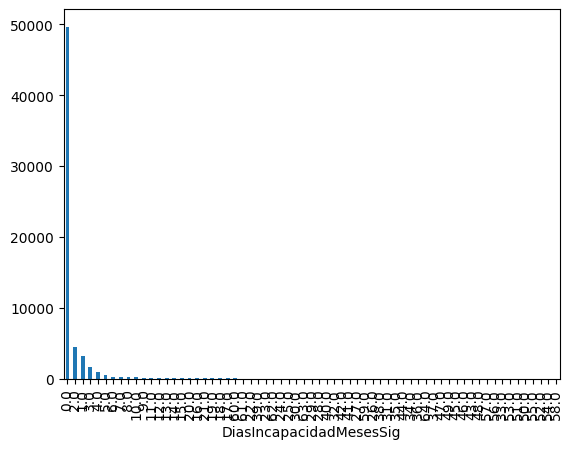

In [ ]:
# Gráfico con conteo de los valores de la variable objetivo
df_incapacidad_numerica['DiasIncapacidadMesesSig'].value_counts().plot.bar()
plt.show()

In [ ]:
# Seleccionando solo las variables numéricas
df_variables_numericas = df_incapacidad_numerica.select_dtypes(include=['int', 'float'])

# Se calcula la matriz de correlación para las variables numéricas
matriz_correlacion = df_variables_numericas.corr()

print(matriz_correlacion)

                         AñosEdad  AñosAntiguedad  TipoCargo  Ocupacion  \
AñosEdad                 1.000000        0.840729   0.114219   0.004782   
AñosAntiguedad           0.840729        1.000000   0.135940   0.009658   
TipoCargo                0.114219        0.135940   1.000000   0.007933   
Ocupacion                0.004782        0.009658   0.007933   1.000000   
Ausencia                 0.076063        0.090224  -0.006152  -0.073154   
Adherencia              -0.011311       -0.005997   0.023142   0.469409   
FTEMenorAdherencia       0.037806        0.030514  -0.007754  -0.183329   
FTEMayorAdherencia       0.003748        0.004904   0.039867   0.450729   
RiesgoPsicosocial        0.025130        0.031341  -0.004222   0.326233   
MesesPermanencia         0.028362        0.024371   0.004320   0.195473   
CondicionEspecial        0.110344        0.104532  -0.011888  -0.032677   
DiasIncapacidad          0.070026        0.069361  -0.008722  -0.037148   
DiasVacaciones           

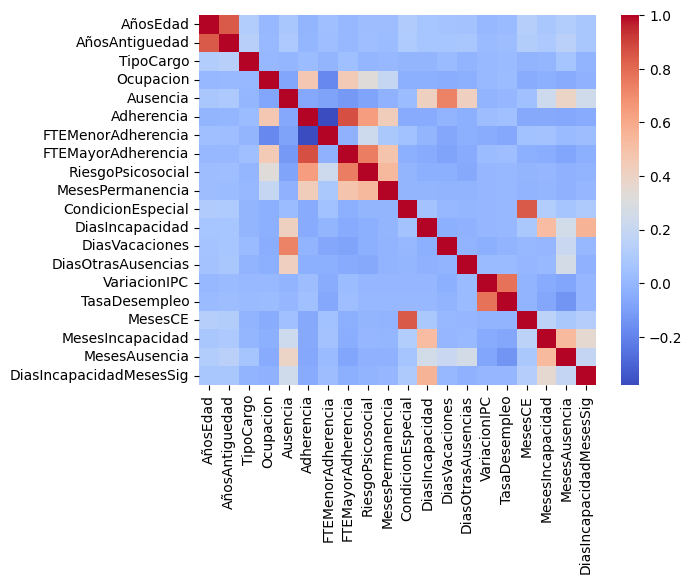

In [ ]:
# Visualicemos la matriz de correlación como una gráfica de calor
sns.heatmap(matriz_correlacion, cmap='coolwarm')
plt.show()

In [ ]:
#Estableciendo un umbral para identificar las correlaciones más altas entre variables predictoras
threshold = 0.7
high_correlations = (matriz_correlacion.abs() > threshold) & (matriz_correlacion.abs() < 1.0)

# Mostrar las variables correlacionadas junto con sus valores de correlación
for col in high_correlations.columns:
    correlated_vars = high_correlations.index[high_correlations[col]].tolist()
    for var in correlated_vars:
        correlation_value = matriz_correlacion.loc[var, col]
        if isinstance(correlation_value, (int, float)):
            print(f"{var} y {col} tienen una correlación de {correlation_value:.2f}")
        else:
            print(f"{var} y {col} tienen una correlación de {correlation_value}")

AñosAntiguedad y AñosEdad tienen una correlación de 0.84
AñosEdad y AñosAntiguedad tienen una correlación de 0.84
DiasVacaciones y Ausencia tienen una correlación de 0.73
FTEMayorAdherencia y Adherencia tienen una correlación de 0.87
Adherencia y FTEMayorAdherencia tienen una correlación de 0.87
RiesgoPsicosocial y FTEMayorAdherencia tienen una correlación de 0.75
FTEMayorAdherencia y RiesgoPsicosocial tienen una correlación de 0.75
MesesCE y CondicionEspecial tienen una correlación de 0.84
Ausencia y DiasVacaciones tienen una correlación de 0.73
TasaDesempleo y VariacionIPC tienen una correlación de 0.78
VariacionIPC y TasaDesempleo tienen una correlación de 0.78
CondicionEspecial y MesesCE tienen una correlación de 0.84


In [ ]:
# Calcula las correlaciones entre la variable objetivo y las variables predictoras numéricas
correlations = df_variables_numericas.corrwith(df_incapacidad_numerica['DiasIncapacidadMesesSig']).sort_values(ascending=False)

pd.set_option('display.max_rows', None)

# Imprimir las correlaciones
print("Correlaciones con la variable objetivo:")
print(correlations)

Correlaciones con la variable objetivo:
DiasIncapacidadMesesSig    1.000000
DiasIncapacidad            0.563241
MesesIncapacidad           0.356432
Ausencia                   0.244706
MesesAusencia              0.188588
MesesCE                    0.123855
CondicionEspecial          0.096859
AñosEdad                   0.084272
AñosAntiguedad             0.082888
FTEMenorAdherencia         0.026338
DiasVacaciones             0.003818
VariacionIPC               0.001626
TasaDesempleo              0.001410
MesesPermanencia          -0.001042
TipoCargo                 -0.013475
RiesgoPsicosocial         -0.017271
DiasOtrasAusencias        -0.019959
Ocupacion                 -0.028038
FTEMayorAdherencia        -0.034834
Adherencia                -0.050490
dtype: float64


## 5 Preprocesamiento

*   Exclusión características con alta correlación
*   Separación conjuntos de entrenamiento y de prueba
*   Pipeline transformación de variables

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

from sklearn.compose import ColumnTransformer

In [ ]:
# Eliminando variables que presentaron alta correlación con otras variables predictoras

#df_incapacidad_binaria1 = df_incapacidad_binaria
df_incapacidad_numerica1 = df_incapacidad_numerica.drop(columns = ['AñosEdad', 'DiasVacaciones', 'FTEMayorAdherencia', 'VariacionIPC', 'TipoCargo', 'Ciudad', 'CondicionEspecial', 'Adherencia', 'RiesgoPsicosocial'])
#df_incapacidad_numerica1 = df_incapacidad_numerica.drop(columns = ['AñosEdad', 'DiasVacaciones', 'FTEMayorAdherencia', 'VariacionIPC', 'TipoCargo', 'Ciudad', 'CondicionEspecial', 'Mes', 'Año', 'Sexo', 'EstadoCivil', 'TipoContrato', 'Cargo', 'Area', 'Region', 'Adherencia', 'RiesgoPsicosocial'])
df_incapacidad_numerica1.shape

(63502, 20)

In [ ]:
df_incapacidad_numerica1.head()

,Mes,Año,Sexo,EstadoCivil,TipoContrato,AñosAntiguedad,Cargo,Area,Region,Ocupacion,Ausencia,FTEMenorAdherencia,MesesPermanencia,DiasIncapacidad,DiasOtrasAusencias,TasaDesempleo,MesesCE,MesesIncapacidad,MesesAusencia,DiasIncapacidadMesesSig
0,April,2023,Femenino,Soltero,Definido,1,Temporal/Aprendiz/Prestamo,Vice Corp,Bogota/Cundinamarca,0.944400,0.611111,0.000000,0.0,0.0,0.0,10.7,0,0,1,0.0
1,April,2023,Femenino,Casado,Definido,1,Auxiliar,Vice Negocios (Otros),Bogota/Cundinamarca,1.177367,0.000000,0.079861,0.0,0.0,0.0,10.7,0,0,0,0.0
2,April,2023,Femenino,Soltero,Indefinido,3,Auxiliar,Canales,Antioquia,1.084889,0.000000,0.013889,0.0,0.0,0.0,10.7,0,0,0,0.0
3,April,2023,Masculino,Soltero,Definido,2,Temporal/Aprendiz/Prestamo,Evolucion Op,Antioquia,1.033944,0.000000,0.027778,0.0,0.0,0.0,10.7,0,0,0,0.0
4,April,2023,Femenino,Soltero,Definido,0,Temporal/Aprendiz/Prestamo,Canales,Antioquia,1.043261,0.000000,0.027778,0.0,0.0,0.0,10.7,0,0,1,0.0


In [ ]:
# Separando los datos en conjunto de entrenamiento y conjunto de prueba

X_train, X_test, y_train, y_test = train_test_split(
    df_incapacidad_numerica1.drop(columns = 'DiasIncapacidadMesesSig'),
    df_incapacidad_numerica1[['DiasIncapacidadMesesSig']], test_size = 0.2,
    random_state = 42, stratify = df_incapacidad_numerica1.DiasIncapacidadMesesSig
    )

In [ ]:
y_train.value_counts()

DiasIncapacidadMesesSig
0.0                        39728
2.0                         3632
1.0                         2592
3.0                         1387
4.0                          761
5.0                          481
6.0                          257
7.0                          252
8.0                          217
10.0                         178
9.0                          150
11.0                         126
12.0                          84
13.0                          83
14.0                          64
15.0                          53
20.0                          50
16.0                          46
21.0                          46
19.0                          42
18.0                          40
17.0                          39
60.0                          39
61.0                          37
22.0                          26
39.0                          23
23.0                          22
62.0                          21
24.0                          18
25.0               

In [ ]:
X_train.head()

,Mes,Año,Sexo,EstadoCivil,TipoContrato,AñosAntiguedad,Cargo,Area,Region,Ocupacion,Ausencia,FTEMenorAdherencia,MesesPermanencia,DiasIncapacidad,DiasOtrasAusencias,TasaDesempleo,MesesCE,MesesIncapacidad,MesesAusencia
50400,August,2022,Femenino,Soltero,Indefinido,16,Supernumerario,Originacion,Antioquia,1.010230,0.045455,0.000000,0.0,0.0,1.0,10.6,0,2,3
2211,April,2023,Femenino,Soltero,Indefinido,15,Auxiliar,Leasing,Antioquia,1.010900,0.000000,0.020833,0.0,0.0,0.0,10.7,0,0,0
43923,June,2022,Femenino,Soltero,Indefinido,9,Analista,Productos,Antioquia,1.046875,0.150000,0.000000,0.0,0.0,0.0,11.3,0,0,3
55419,October,2022,Femenino,Soltero,Definido,0,Auxiliar,Originacion,Antioquia,1.143400,0.000000,0.025000,0.0,0.0,0.0,9.7,0,0,2
7552,June,2023,Femenino,Soltero,Indefinido,5,Supernumerario,Originacion,Antioquia,0.881250,0.100000,0.018750,0.0,2.0,0.0,9.3,0,1,3


In [ ]:
# Creación de pipeline para la normalización de las variables numéricas y la codificación de las variables categóricas

#Identificar variables numéricas NO binarias y variables categóricas
#num_cols = ['AñosAntiguedad', 'Ocupacion', 'Ausencia', 'Adherencia', 'FTEMenorAdherencia', 'MesesPermanencia', 'DiasIncapacidad', 'DiasOtrasAusencias', 'TasaDesempleo', 'MesesCE', 'MesesIncapacidad', 'MesesAusencia']
num_cols = ['AñosAntiguedad', 'Ocupacion', 'Ausencia', 'FTEMenorAdherencia', 'MesesPermanencia', 'DiasIncapacidad', 'DiasOtrasAusencias', 'TasaDesempleo', 'MesesCE', 'MesesIncapacidad', 'MesesAusencia']
#cat_cols = ['Mes','Año', 'Sexo', 'EstadoCivil', 'TipoContrato', 'Cargo', 'Area', 'Region']
cat_cols = ['Mes','Año', 'Sexo', 'EstadoCivil', 'TipoContrato', 'Cargo', 'Area', 'Region']
#num_cols_sincambio = ['RiesgoPsicosocial']
num_cols_sincambio = []

#NOTA:
#No se incluyo para estandarizar la variable 'TipoCargo' porque ya es binaria.
#No se incluyo para estandarizar la variable 'RiesgoPsicosocial' porque solo toma los valores de 0 a 4, como un ordinal encoder (como categorica).

# Crear un transformador para las variables categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Crear un transformador para las variables numéricas
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combinar los transformadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols),
        ('passthrough', 'passthrough', num_cols_sincambio)
    ])

In [ ]:
cat_cols

['Mes',
 'Año',
 'Sexo',
 'EstadoCivil',
 'TipoContrato',
 'Cargo',
 'Area',
 'Region']

In [ ]:
num_cols

['AñosAntiguedad',
 'Ocupacion',
 'Ausencia',
 'FTEMenorAdherencia',
 'MesesPermanencia',
 'DiasIncapacidad',
 'DiasOtrasAusencias',
 'TasaDesempleo',
 'MesesCE',
 'MesesIncapacidad',
 'MesesAusencia']

In [ ]:
#Definición de Pipeline
pipeline_transformacion = Pipeline(steps = [
    ('preprocessor', preprocessor)
    ])

In [ ]:
#Aplicando pipeline de transformacion a las variables en X_train
X_train_transformed = pipeline_transformacion.fit_transform(X_train)

In [ ]:
# Obtener los nombres de las columnas transformadas
column_names_categorical = pipeline_transformacion.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=cat_cols)

column_names_numeric = num_cols + num_cols_sincambio

# Combinar los nombres de las columnas categóricas transformadas con los nombres de las columnas numéricas y sin cambio
column_names_all = list(column_names_categorical) + column_names_numeric

# Crear un DataFrame con las variables transformadas
X_train_transformed = pd.DataFrame(X_train_transformed, columns=column_names_all)

In [ ]:
X_train_transformed.head()

,Mes_August,Mes_December,Mes_February,Mes_January,Mes_July,Mes_June,Mes_March,Mes_May,Mes_November,Mes_October,Mes_September,Año_2023,Sexo_Masculino,EstadoCivil_Soltero,TipoContrato_Indefinido,Cargo_Auxiliar,Cargo_Diseñador procesos,Cargo_Otros cargos,Cargo_Supernumerario,Cargo_Temporal/Aprendiz/Prestamo,Area_Clientes Emp (Otros),Area_Evolucion Op,Area_Func Corp,Area_Leasing,Area_MK,Area_Originacion,Area_Otras areas,Area_Productos,Area_Serv Administrativos,Area_Vice Corp,Area_Vice Negocios (Otros),Region_Bogota/Cundinamarca,Region_Caribe,Region_Centro y otros,Region_Pacifico,AñosAntiguedad,Ocupacion,Ausencia,FTEMenorAdherencia,MesesPermanencia,DiasIncapacidad,DiasOtrasAusencias,TasaDesempleo,MesesCE,MesesIncapacidad,MesesAusencia
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.762781,-0.123129,-0.250105,-0.439565,-0.246509,-0.198588,0.314403,-0.185196,-0.114311,2.383496,1.646042
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636795,-0.117909,-0.463167,0.530319,-0.246509,-0.198588,-0.205265,-0.114219,-0.114311,-0.489367,-1.180283
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.119119,0.162373,0.239930,-0.439565,-0.246509,-0.198588,-0.205265,0.311643,-0.114311,-0.489367,1.646042
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.252989,0.914401,-0.463167,0.724295,-0.246509,-0.198588,-0.205265,-0.823988,-0.114311,-0.489367,0.703934
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.623061,-1.128014,0.005564,0.433330,-0.246509,0.810513,-0.205265,-1.107896,-0.114311,0.947065,1.646042


## 6 Implementación de modelos

### 6.1 Regresión de Poisson (GLM)

In [ ]:
# Librerias
import statsmodels.api as sm

In [ ]:
# Añade una constante al conjunto de características de entrenamiento
X_train_transformed = sm.add_constant(X_train_transformed)

In [ ]:
print(y_train.index)

Index([50400,  2211, 43923, 55419,  7552, 39068, 47548,  5946, 42334, 44573,
       ...
       59212, 36778,  2767, 12820, 25181, 57135, 38944, 51450, 54116,  7717],
      dtype='int64', length=50801)


In [ ]:
print(X_train_transformed.index)

RangeIndex(start=0, stop=50801, step=1)


In [ ]:
print(X_train.index)

Index([50400,  2211, 43923, 55419,  7552, 39068, 47548,  5946, 42334, 44573,
       ...
       59212, 36778,  2767, 12820, 25181, 57135, 38944, 51450, 54116,  7717],
      dtype='int64', length=50801)


In [ ]:
#Reseteando los indices de ambos dataframes para que comiencen desde cero y estén alineados.
y_train.reset_index(drop=True, inplace=True)
X_train_transformed.reset_index(drop=True, inplace=True)

In [ ]:
#Transformando a y_train
#y_train = np.sqrt(y_train)

In [ ]:
# Crea un modelo de regresión de Poisson
poisson_model = sm.GLM(y_train, X_train_transformed, family=sm.families.Poisson())

In [ ]:
# Ajusta el modelo a los datos de entrenamiento
poisson_results = poisson_model.fit(maxiter=1000)
#poisson_results = poisson_model.fit_regularized()

In [ ]:
#Aplicando transformacion a las variables en X_test
X_test_transformed = pipeline_transformacion.fit_transform(X_test)

In [ ]:
# Obtener los nombres de las columnas transformadas
column_names_categorical = pipeline_transformacion.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=cat_cols)

column_names_numeric = num_cols + num_cols_sincambio

# Combinar los nombres de las columnas categóricas transformadas con los nombres de las columnas numéricas y sin cambio
column_names_all = list(column_names_categorical) + column_names_numeric

# Crear un DataFrame con las variables transformadas
X_test_transformed = pd.DataFrame(X_test_transformed, columns=column_names_all)

In [ ]:
X_test_transformed.head()

,Mes_August,Mes_December,Mes_February,Mes_January,Mes_July,Mes_June,Mes_March,Mes_May,Mes_November,Mes_October,Mes_September,Año_2023,Sexo_Masculino,EstadoCivil_Soltero,TipoContrato_Indefinido,Cargo_Auxiliar,Cargo_Diseñador procesos,Cargo_Otros cargos,Cargo_Supernumerario,Cargo_Temporal/Aprendiz/Prestamo,Area_Clientes Emp (Otros),Area_Evolucion Op,Area_Func Corp,Area_Leasing,Area_MK,Area_Originacion,Area_Otras areas,Area_Productos,Area_Serv Administrativos,Area_Vice Corp,Area_Vice Negocios (Otros),Region_Bogota/Cundinamarca,Region_Caribe,Region_Centro y otros,Region_Pacifico,AñosAntiguedad,Ocupacion,Ausencia,FTEMenorAdherencia,MesesPermanencia,DiasIncapacidad,DiasOtrasAusencias,TasaDesempleo,MesesCE,MesesIncapacidad,MesesAusencia
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.246305,0.393193,0.437996,-0.465589,-0.246953,-0.198541,1.743235,1.999667,-0.113047,-0.487346,-0.242262
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.493193,-0.123672,-0.462029,0.553447,-0.246953,-0.198541,-0.209563,0.238423,-0.113047,-0.487346,-1.185827
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.235024,1.285179,-0.462029,-0.465589,4.129113,-0.198541,-0.209563,2.633715,-0.113047,-0.487346,-1.185827
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.740082,1.442691,-0.462029,-0.465589,-0.246953,-0.198541,-0.209563,-0.113826,-0.113047,-0.487346,0.701303
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.864692,1.486214,-0.462029,-0.465589,0.847064,-0.198541,-0.209563,-0.184275,-0.113047,-0.487346,-1.185827


In [ ]:
# Añade una constante al conjunto de características de prueba
X_test_transformed = sm.add_constant(X_test_transformed)

In [ ]:
#Reseteando los indices de ambos dataframes para que comiencen desde cero y estén alineados.
y_test.reset_index(drop=True, inplace=True)
X_test_transformed.reset_index(drop=True, inplace=True)

In [ ]:
# Realiza predicciones en los datos de prueba
y_pred = poisson_results.predict(X_test_transformed)

# Imprime el resumen del modelo
print(poisson_results.summary())

                    Generalized Linear Model Regression Results                    
Dep. Variable:     DiasIncapacidadMesesSig   No. Observations:                50801
Model:                                 GLM   Df Residuals:                    50754
Model Family:                      Poisson   Df Model:                           46
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:            -1.0246e+05
Date:                     Wed, 05 Jun 2024   Deviance:                   1.7207e+05
Time:                             16:38:06   Pearson chi2:                 4.77e+05
No. Iterations:                          7   Pseudo R-squ. (CS):             0.8380
Covariance Type:                 nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [ ]:
#Evaluar MSE, MAE, R^2, MaxError y MedianAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, max_error, median_absolute_error

model_MSE = mean_squared_error(y_test, y_pred)
model_MAE = mean_absolute_error(y_test, y_pred)
#model_MAPE = mean_absolute_percentage_error(y_test, y_pred)
model_R2 = r2_score(y_test, y_pred)
model_max_error = max_error(y_test, y_pred)
model_MedianAE = median_absolute_error(y_test, y_pred)

In [ ]:
print(f'model_MSE: {model_MSE}, model_MAE: {model_MAE}, model_R^2: {model_R2}, model_max_error: {model_max_error}, model_MedianAE: {model_MedianAE}')

model_MSE: 14.46630027675527, model_MAE: 1.4238425106496015, model_R^2: 0.37347615981689053, model_max_error: 68.79999569403513, model_MedianAE: 0.7157613665659136


In [ ]:
# Obtener los residuos del modelo
#residuos = poisson_results.resid_deviance
#residuos = poisson_results.resid_response
residuos = poisson_results.resid_pearson
#print (residuos)

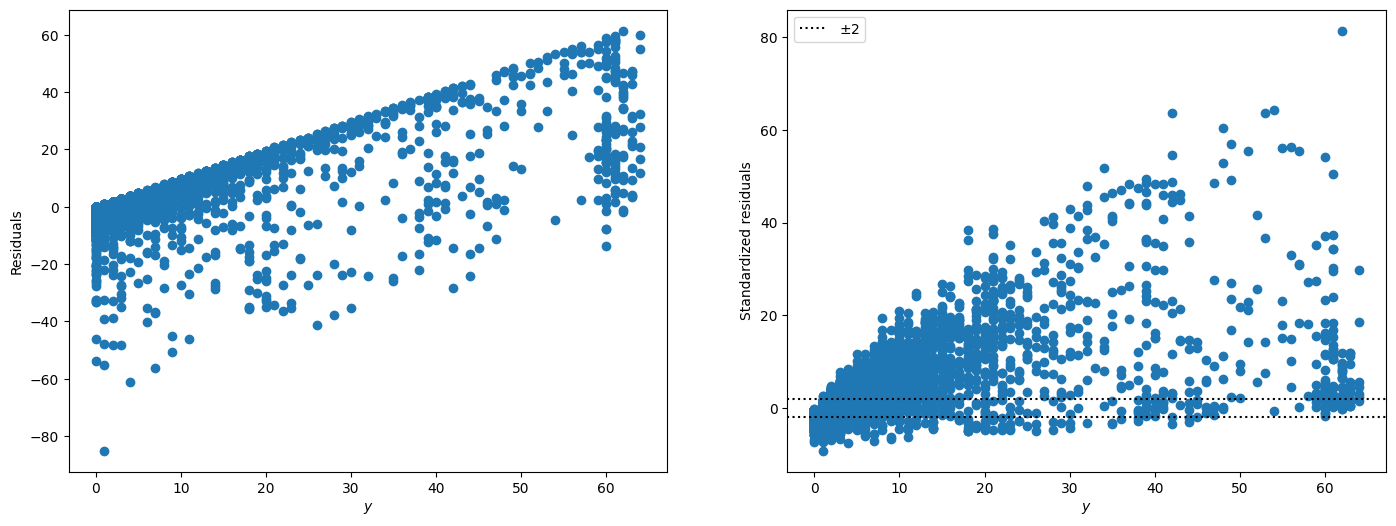

In [ ]:
# Graficando los residuos
f, axes = plt.subplots(1, 2, figsize=(17, 6))
axes[0].plot(y_train, poisson_results.resid_response, 'o')
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("$y$")
axes[1].plot(y_train, poisson_results.resid_pearson, 'o')
axes[1].axhline(y=-2, linestyle=':', color='black', label='$\pm 2$')
axes[1].axhline(y=+2, linestyle=':', color='black')
axes[1].set_ylabel("Standardized residuals")
axes[1].set_xlabel("$y$")
plt.legend()
plt.show()

In [ ]:
#Calculo ratio de sobredispersion R, si es mayor que 1 entonces hay sobredispersion.
R = poisson_results.pearson_chi2 / poisson_results.df_resid
print(R)

9.393483847211188


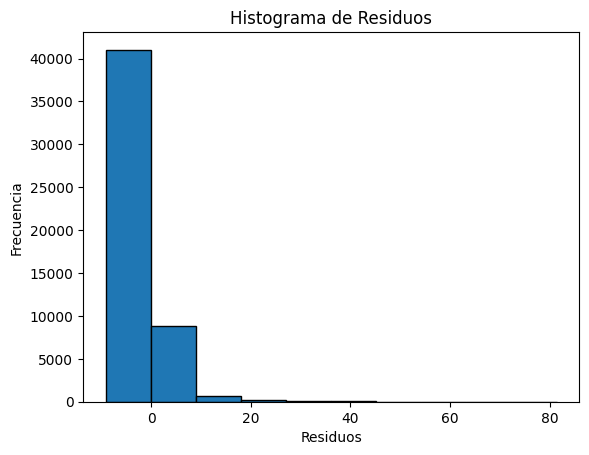

In [ ]:
# Histograma de residuos (residuos pearson)
plt.hist(residuos, bins=10, edgecolor='black')
plt.title('Histograma de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

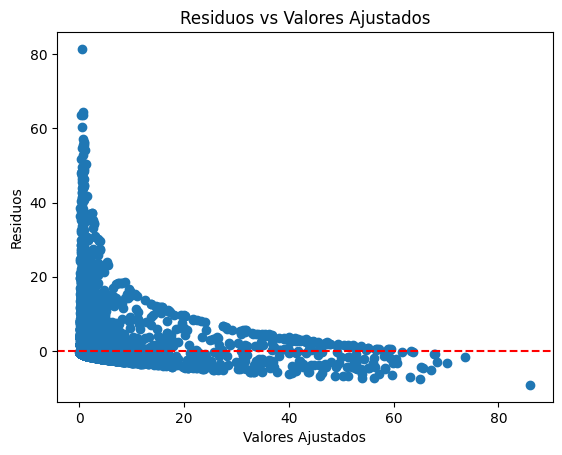

In [ ]:
# Gráfico de residuos vs valores ajustados
plt.scatter(poisson_results.fittedvalues, residuos)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuos vs Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()

In [ ]:
# Verificando el porcentaje de residuos que estan en el rango de -2 a 2
import numpy as np
from scipy.stats import norm

# Define los límites del rango que deseas verificar
lower_limit = -2
upper_limit = 2

# Verifica cuántos de los residuos están dentro de estos límites
residuals_within_range = residuos[(residuos >= lower_limit) & (residuos <= upper_limit)]
percentage_within_range = len(residuals_within_range) / len(residuos) * 100

print("Porcentaje de residuos dentro del rango (-2, 2):", percentage_within_range)

Porcentaje de residuos dentro del rango (-2, 2): 90.62813724139288


In [ ]:
# Porcentaje de residuos por fuera del rango de -2 a 2
residuals_outside_range = residuos[(residuos < lower_limit) | (residuos > upper_limit)]
percentage_outside_range = len(residuals_outside_range) / len(residuos) * 100

print("Porcentaje de residuos por fuera del rango (-2, 2):", percentage_outside_range)

Porcentaje de residuos por fuera del rango (-2, 2): 9.371862758607113


In [ ]:
# Cálculo AIC y BIC
poisson_aic = poisson_results.aic
poisson_bic = poisson_results.bic
print(f'POISSON AIC: {poisson_aic}, BIC: {poisson_bic}')

POISSON AIC: 205018.02532381765, BIC: -377885.5157879092


In [ ]:
# Obtener la log-likelihood
poisson_log_likelihood = poisson_results.llf
print(f'Log-Likelihood POISSON: {poisson_log_likelihood}')

Log-Likelihood POISSON: -102462.01266190883


In [ ]:
# Calcular la media y la varianza de la variable dependiente
media_diasincapacidad = np.mean(y_train)
varianza_diasincapacidad = np.var(y_train)

print("Media de la variable dependiente dias de incapacidad:", media_diasincapacidad)
print("Varianza de la variable dependiente dias de incapacidad:", varianza_diasincapacidad)

Media de la variable dependiente dias de incapacidad: 1.1484616444558178
Varianza de la variable dependiente dias de incapacidad: DiasIncapacidadMesesSig    23.137621
dtype: float64


In [ ]:
# Prueba de Cameron y Trivedi para sobredispersión
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Realizar la prueba de Cameron y Trivedi para verificar si hay sobredispersion
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = het_breuschpagan(poisson_results.resid_response, poisson_results.model.exog)

# Usar zip para mostrar los resultados de la prueba de Cameron y Trivedi
test_results = dict(zip(name, test))
print(test_results)

{'Lagrange multiplier statistic': 6911.953778954353, 'p-value': 0.0, 'f-value': 173.7629279436439, 'f p-value': 0.0}


### 6.2 Regresión Binomial Negativa (GLM)

In [ ]:
# Librerias
import statsmodels.api as sm

In [ ]:
# Añade una constante al conjunto de características de entrenamiento
X_train_transformed = sm.add_constant(X_train_transformed)

In [ ]:
#Reseteando los indices de ambos dataframes para que comiencen desde cero y estén alineados.
y_train.reset_index(drop=True, inplace=True)
X_train_transformed.reset_index(drop=True, inplace=True)

In [ ]:
# Crea un modelo de regresión binomial negativa
negbinomial_model = sm.GLM(y_train, X_train_transformed, family=sm.families.NegativeBinomial(alpha=1.0))

In [ ]:
# Ajusta el modelo a los datos de entrenamiento
negbinomial_results = negbinomial_model.fit(maxiter=1000)
#negbinomial_results = negbinomial_model.fit_regularized()

In [ ]:
#Aplicando transformacion a las variables en X_test
X_test_transformed = pipeline_transformacion.fit_transform(X_test)

In [ ]:
# Obtener los nombres de las columnas transformadas
column_names_categorical = pipeline_transformacion.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=cat_cols)

column_names_numeric = num_cols + num_cols_sincambio

# Combinar los nombres de las columnas categóricas transformadas con los nombres de las columnas numéricas y sin cambio
column_names_all = list(column_names_categorical) + column_names_numeric

# Crear un DataFrame con las variables transformadas
X_test_transformed = pd.DataFrame(X_test_transformed, columns=column_names_all)

In [ ]:
X_test_transformed.head()

,Mes_August,Mes_December,Mes_February,Mes_January,Mes_July,Mes_June,Mes_March,Mes_May,Mes_November,Mes_October,Mes_September,Año_2023,Sexo_Masculino,EstadoCivil_Soltero,TipoContrato_Indefinido,Cargo_Auxiliar,Cargo_Diseñador procesos,Cargo_Otros cargos,Cargo_Supernumerario,Cargo_Temporal/Aprendiz/Prestamo,Area_Clientes Emp (Otros),Area_Evolucion Op,Area_Func Corp,Area_Leasing,Area_MK,Area_Originacion,Area_Otras areas,Area_Productos,Area_Serv Administrativos,Area_Vice Corp,Area_Vice Negocios (Otros),Region_Bogota/Cundinamarca,Region_Caribe,Region_Centro y otros,Region_Pacifico,AñosAntiguedad,Ocupacion,Ausencia,FTEMenorAdherencia,MesesPermanencia,DiasIncapacidad,DiasOtrasAusencias,TasaDesempleo,MesesCE,MesesIncapacidad,MesesAusencia
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.246305,0.393193,0.437996,-0.465589,-0.246953,-0.198541,1.743235,1.999667,-0.113047,-0.487346,-0.242262
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.493193,-0.123672,-0.462029,0.553447,-0.246953,-0.198541,-0.209563,0.238423,-0.113047,-0.487346,-1.185827
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.235024,1.285179,-0.462029,-0.465589,4.129113,-0.198541,-0.209563,2.633715,-0.113047,-0.487346,-1.185827
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.740082,1.442691,-0.462029,-0.465589,-0.246953,-0.198541,-0.209563,-0.113826,-0.113047,-0.487346,0.701303
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.864692,1.486214,-0.462029,-0.465589,0.847064,-0.198541,-0.209563,-0.184275,-0.113047,-0.487346,-1.185827


In [ ]:
# Añade una constante al conjunto de características de prueba
X_test_transformed = sm.add_constant(X_test_transformed)

In [ ]:
#Reseteando los indices de ambos dataframes para que comiencen desde cero y estén alineados.
y_test.reset_index(drop=True, inplace=True)
X_test_transformed.reset_index(drop=True, inplace=True)

In [ ]:
# Realiza predicciones en los datos de prueba
y_pred = negbinomial_results.predict(X_test_transformed)

# Imprime el resumen del modelo
print(negbinomial_results.summary())

                    Generalized Linear Model Regression Results                    
Dep. Variable:     DiasIncapacidadMesesSig   No. Observations:                50801
Model:                                 GLM   Df Residuals:                    50754
Model Family:             NegativeBinomial   Df Model:                           46
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -61576.
Date:                     Tue, 04 Jun 2024   Deviance:                       73299.
Time:                             23:05:48   Pearson chi2:                 2.69e+05
No. Iterations:                         10   Pseudo R-squ. (CS):             0.4195
Covariance Type:                 nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [ ]:
#Evaluar MSE, MAE, R^2, MaxError y MedianAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, max_error, median_absolute_error

model_MSE = mean_squared_error(y_test, y_pred)
model_MAE = mean_absolute_error(y_test, y_pred)
#model_MAPE = mean_absolute_percentage_error(y_test, y_pred)
model_R2 = r2_score(y_test, y_pred)
model_max_error = max_error(y_test, y_pred)
model_MedianAE = median_absolute_error(y_test, y_pred)

In [ ]:
print(f'model_MSE: {model_MSE}, model_MAE: {model_MAE}, model_R^2: {model_R2}, model_max_error: {model_max_error}, model_MedianAE: {model_MedianAE}')

model_MSE: 22.348659608876776, model_MAE: 1.5022154346072474, model_R^2: 0.03209751123462712, model_max_error: 128.37033289291801, model_MedianAE: 0.6660608149662934


In [ ]:
#Calculo ratio de sobredispersion R, si es mayor que 1 entonces hay sobredispersion.
R = negbinomial_results.pearson_chi2 / negbinomial_results.df_resid
print(R)

5.2903303954961265


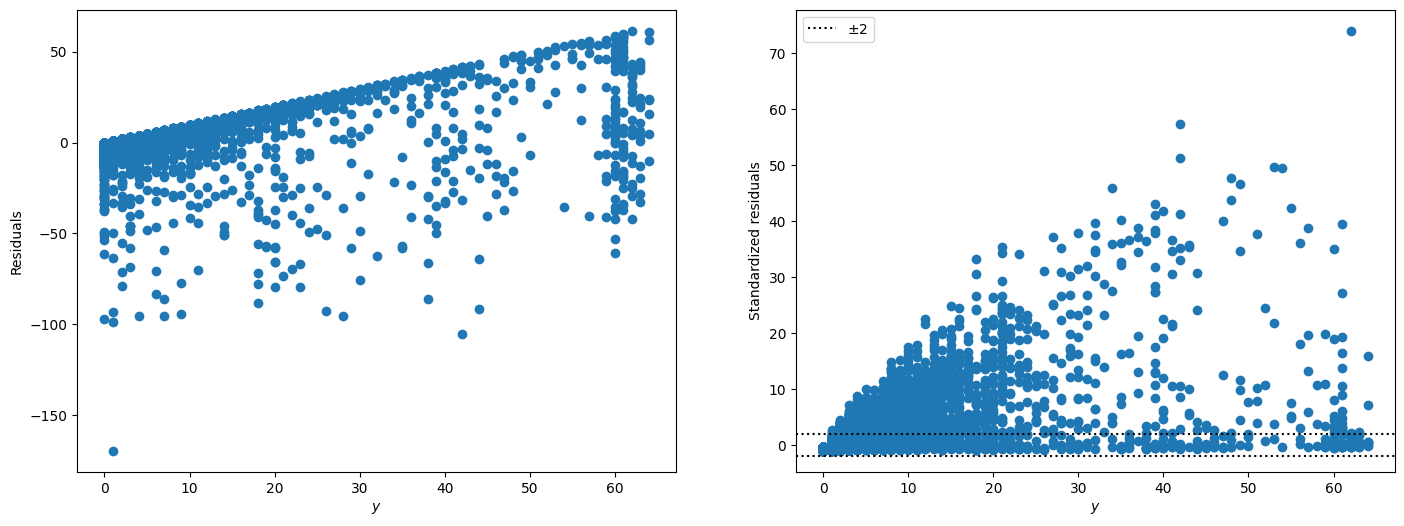

In [ ]:
# Graficando los residuos
f, axes = plt.subplots(1, 2, figsize=(17, 6))
axes[0].plot(y_train, negbinomial_results.resid_response, 'o')
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("$y$")
axes[1].plot(y_train, negbinomial_results.resid_pearson, 'o')
axes[1].axhline(y=-2, linestyle=':', color='black', label='$\pm 2$')
axes[1].axhline(y=+2, linestyle=':', color='black')
axes[1].set_ylabel("Standardized residuals")
axes[1].set_xlabel("$y$")
plt.legend()
plt.show()

In [ ]:
# Obtener los residuos del modelo
#residuos = negbinomial_results.resid_deviance
#residuos = negbinomial_results.resid_response
residuos = negbinomial_results.resid_pearson
#print (residuos)

In [ ]:
# Verificando el porcentaje de residuos que estan en el rango de -2 a 2
import numpy as np
from scipy.stats import norm

# Define los límites del rango que deseas verificar
lower_limit = -2
upper_limit = 2

# Verifica cuántos de los residuos están dentro de estos límites
residuals_within_range = residuos[(residuos >= lower_limit) & (residuos <= upper_limit)]
percentage_within_range = len(residuals_within_range) / len(residuos) * 100

print("Porcentaje de residuos dentro del rango (-2, 2):", percentage_within_range)

Porcentaje de residuos dentro del rango (-2, 2): 93.42335780791716


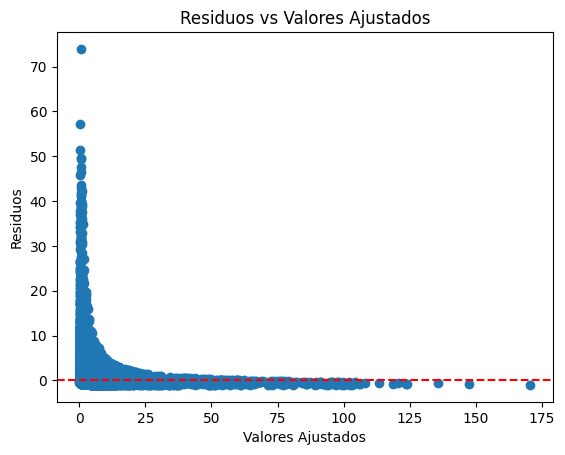

In [ ]:
# Gráfico de residuos vs valores ajustados
plt.scatter(negbinomial_results.fittedvalues, residuos)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuos vs Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()

In [ ]:
# Cálculo AIC y BIC
negbinomial_aic = negbinomial_results.aic
negbinomial_bic = negbinomial_results.bic
print(f'NEGBINOMIAL AIC: {negbinomial_aic}, BIC: {negbinomial_bic}')

NEGBINOMIAL AIC: 123245.12697816714, BIC: -476654.5671473398


In [ ]:
# Obtener la log-likelihood
negbinomial_log_likelihood = negbinomial_results.llf
print(f'Log-Likelihood NEGBINOMIAL: {negbinomial_log_likelihood}')

Log-Likelihood NEGBINOMIAL: -61575.56348908357


### 6.3 Regresión Poisson con Inflación de Ceros (ZIP)

In [ ]:
# Librerias
import statsmodels.api as sm
import cvxopt

In [ ]:
# Añade una constante al conjunto de características de entrenamiento
X_train_transformed = sm.add_constant(X_train_transformed)

In [ ]:
print(y_train.index)

RangeIndex(start=0, stop=50801, step=1)


In [ ]:
print(X_train_transformed.index)

RangeIndex(start=0, stop=50801, step=1)


In [ ]:
print(X_train.index)

Index([50400,  2211, 43923, 55419,  7552, 39068, 47548,  5946, 42334, 44573,
       ...
       59212, 36778,  2767, 12820, 25181, 57135, 38944, 51450, 54116,  7717],
      dtype='int64', length=50801)


In [ ]:
#Reseteando los indices de ambos dataframes para que comiencen desde cero y estén alineados.
y_train.reset_index(drop=True, inplace=True)
X_train_transformed.reset_index(drop=True, inplace=True)

In [ ]:
# Ajustar el modelo de regresión de Poisson con inflación de ceros en el conjunto de entrenamiento
zip_model = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train_transformed, exog_infl=X_train_transformed, inflation='logit')

In [ ]:
# Ajustar el modelo a los datos
zip_result = zip_model.fit(maxiter=1000, method='bfgs', cov_type='nonrobust')
#zip_result = zip_model.fit(method='basinhopping', niter= 10000, niter_success=10000)
#zip_result = zip_model.fit_regularized(method='l1', alpha=0, trim_mode='auto', auto_trim_tol=0.01)

Optimization terminated successfully.
         Current function value: 1.286091
         Iterations: 216
         Function evaluations: 222
         Gradient evaluations: 222


In [ ]:
#Aplicando transformacion a las variables en X_test
X_test_transformed = pipeline_transformacion.fit_transform(X_test)

In [ ]:
# Obtener los nombres de las columnas transformadas
column_names_categorical = pipeline_transformacion.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=cat_cols)

column_names_numeric = num_cols + num_cols_sincambio

# Combinar los nombres de las columnas categóricas transformadas con los nombres de las columnas numéricas y sin cambio
column_names_all = list(column_names_categorical) + column_names_numeric

# Crear un DataFrame con las variables transformadas
X_test_transformed = pd.DataFrame(X_test_transformed, columns=column_names_all)

In [ ]:
# Añade una constante al conjunto de características de prueba
X_test_transformed = sm.add_constant(X_test_transformed)

In [ ]:
#Reseteando los indices de ambos dataframes para que comiencen desde cero y estén alineados.
y_test.reset_index(drop=True, inplace=True)
X_test_transformed.reset_index(drop=True, inplace=True)

In [ ]:
# Realiza predicciones en los datos de prueba
y_pred = zip_result.predict(X_test_transformed, exog_infl=X_test_transformed)

# Imprime el resumen del modelo
print(zip_result.summary())

                       ZeroInflatedPoisson Regression Results                      
Dep. Variable:     DiasIncapacidadMesesSig   No. Observations:                50801
Model:                 ZeroInflatedPoisson   Df Residuals:                    50754
Method:                                MLE   Df Model:                           46
Date:                     Tue, 04 Jun 2024   Pseudo R-squ.:                  0.2437
Time:                             23:18:10   Log-Likelihood:                -65335.
converged:                            True   LL-Null:                       -86391.
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
inflate_const                                1.5326      0.084     18.171      0.000       1.367       1.698
i

In [ ]:
#Evaluar MSE, MAE, R^2, MaxError y MedianAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, max_error, median_absolute_error

model_MSE = mean_squared_error(y_test, y_pred)
model_MAE = mean_absolute_error(y_test, y_pred)
#model_MAPE = mean_absolute_percentage_error(y_test, y_pred)
model_R2 = r2_score(y_test, y_pred)
model_max_error = max_error(y_test, y_pred)
model_MedianAE = median_absolute_error(y_test, y_pred)

In [ ]:
print(f'model_MSE: {model_MSE}, model_MAE: {model_MAE}, model_R^2: {model_R2}, model_max_error: {model_max_error}, model_MedianAE: {model_MedianAE}')

model_MSE: 13.39159927442287, model_MAE: 1.4098238685390558, model_R^2: 0.4200205966216377, model_max_error: 57.86765872473295, model_MedianAE: 0.6633008734089928


In [ ]:
# Obtener los residuos del modelo
residuos = zip_result.resid_pearson

In [ ]:
# Verificando el porcentaje de residuos que estan en el rango de -2 a 2
import numpy as np
from scipy.stats import norm

# Define los límites del rango que deseas verificar
lower_limit = -2
upper_limit = 2

# Verifica cuántos de los residuos están dentro de estos límites
residuals_within_range = residuos[(residuos >= lower_limit) & (residuos <= upper_limit)]
percentage_within_range = len(residuals_within_range) / len(residuos) * 100

print("Porcentaje de residuos dentro del rango (-2, 2):", percentage_within_range)

Porcentaje de residuos dentro del rango (-2, 2): 95.08867935670557


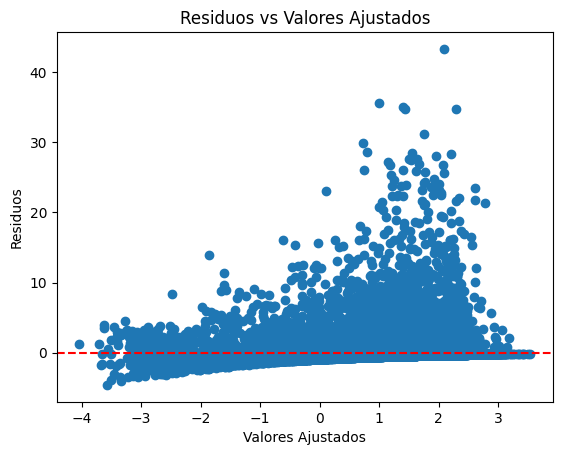

In [ ]:
# Gráfico de residuos vs valores ajustados
plt.scatter(zip_result.fittedvalues, residuos)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuos vs Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()

In [ ]:
# Cálculo de AIC y BIC
zip_aic = zip_result.aic
zip_bic = zip_result.bic
print(f'ZIP AIC: {zip_aic}, BIC: {zip_bic}')

ZIP AIC: 130857.4099854042, BIC: 131687.96308933495


In [ ]:
# Obtener la log-likelihood
zip_log_likelihood = zip_result.llf
print(f'Log-Likelihood ZIP: {zip_log_likelihood}')

Log-Likelihood ZIP: -65334.7049927021


### 6.4 Regresión Binomial Negativa con Inflación de Ceros (ZINB)

In [ ]:
# Librerias
import statsmodels.api as sm

In [ ]:
# Añade una constante al conjunto de características de entrenamiento
X_train_transformed = sm.add_constant(X_train_transformed)

In [ ]:
#Reseteando los indices de ambos dataframes para que comiencen desde cero y estén alineados.
y_train.reset_index(drop=True, inplace=True)
X_train_transformed.reset_index(drop=True, inplace=True)

In [ ]:
# Ajustar el modelo de regresión de Poisson con inflación de ceros en el conjunto de entrenamiento
zinb_model = sm.ZeroInflatedNegativeBinomialP(endog=y_train, exog=X_train_transformed, exog_infl=X_train_transformed, inflation='logit')

In [ ]:
# Ajustar el modelo a los datos
zinb_result = zinb_model.fit(maxiter=100, method='bfgs', cov_type='nonrobust')
#zinb_result = zinb_model.fit(method='basinhopping', niter= 10000, niter_success=10000)
#zinb_result = zinb_model.fit_regularized(method='l1', alpha=0, trim_mode='auto', auto_trim_tol=0.01)

         Current function value: 0.995105
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102


In [ ]:
#Aplicando transformacion a las variables en X_test
X_test_transformed = pipeline_transformacion.fit_transform(X_test)

In [ ]:
# Obtener los nombres de las columnas transformadas
column_names_categorical = pipeline_transformacion.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=cat_cols)

column_names_numeric = num_cols + num_cols_sincambio

# Combinar los nombres de las columnas categóricas transformadas con los nombres de las columnas numéricas y sin cambio
column_names_all = list(column_names_categorical) + column_names_numeric

# Crear un DataFrame con las variables transformadas
X_test_transformed = pd.DataFrame(X_test_transformed, columns=column_names_all)

In [ ]:
# Añade una constante al conjunto de características de prueba
X_test_transformed = sm.add_constant(X_test_transformed)

In [ ]:
#Reseteando los indices de ambos dataframes para que comiencen desde cero y estén alineados.
y_test.reset_index(drop=True, inplace=True)
X_test_transformed.reset_index(drop=True, inplace=True)

In [ ]:
# Realiza predicciones en los datos de prueba
y_pred = zinb_result.predict(X_test_transformed, exog_infl=X_test_transformed)

# Imprime el resumen del modelo
print(zinb_result.summary())

                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:           DiasIncapacidadMesesSig   No. Observations:                50801
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    50754
Method:                                      MLE   Df Model:                           46
Date:                           Tue, 04 Jun 2024   Pseudo R-squ.:                 0.05254
Time:                                   23:37:03   Log-Likelihood:                -50552.
converged:                                 False   LL-Null:                       -53355.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
inflate_const                               -1.0877        nan

In [ ]:
#Evaluar MSE, MAE, R^2, MaxError y MedianAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, max_error, median_absolute_error

model_MSE = mean_squared_error(y_test, y_pred)
model_MAE = mean_absolute_error(y_test, y_pred)
#model_MAPE = mean_absolute_percentage_error(y_test, y_pred)
model_R2 = r2_score(y_test, y_pred)
model_max_error = max_error(y_test, y_pred)
model_MedianAE = median_absolute_error(y_test, y_pred)

In [ ]:
print(f'model_MSE: {model_MSE}, model_MAE: {model_MAE}, model_R^2: {model_R2}, model_max_error: {model_max_error}, model_MedianAE: {model_MedianAE}')

model_MSE: 15.843682888271346, model_MAE: 1.471638106060573, model_R^2: 0.31382282574673315, model_max_error: 77.57098455023204, model_MedianAE: 0.7264642610043579


In [ ]:
# Obtener los residuos del modelo
residuos = zinb_result.resid_pearson

In [ ]:
# Verificando el porcentaje de residuos que estan en el rango de -2 a 2
import numpy as np
from scipy.stats import norm

# Define los límites del rango que deseas verificar
lower_limit = -2
upper_limit = 2

# Verifica cuántos de los residuos están dentro de estos límites
residuals_within_range = residuos[(residuos >= lower_limit) & (residuos <= upper_limit)]
percentage_within_range = len(residuals_within_range) / len(residuos) * 100

print("Porcentaje de residuos dentro del rango (-2, 2):", percentage_within_range)

Porcentaje de residuos dentro del rango (-2, 2): 97.26580185429421


In [ ]:
# Verifica los que residuos están por fuera de estos límites
residuals_outside_range = residuos[(residuos < lower_limit) | (residuos > upper_limit)]
residuals_outside_range

array([15.59802986,  2.06631171,  6.07353009, ...,  4.53792538,
        4.43279407,  5.82811379])

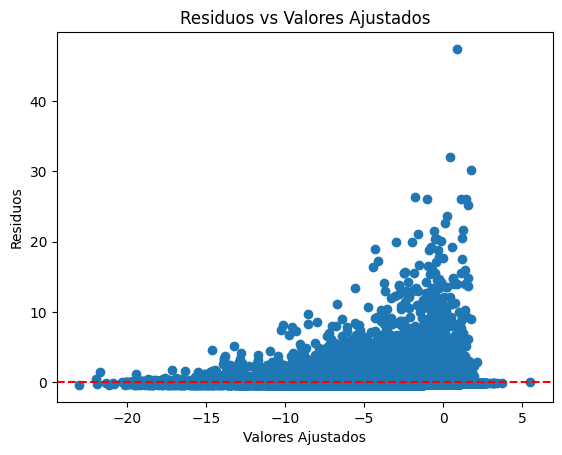

In [ ]:
# Gráfico de residuos vs valores ajustados
plt.scatter(zinb_result.fittedvalues, residuos)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuos vs Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()

In [ ]:
# Cálculo de AIC y BIC
zinb_aic = zinb_result.aic
zinb_bic = zinb_result.bic
print(f'ZINB AIC: {zinb_aic}, BIC: {zinb_bic}')

ZINB AIC: 101294.6542031942, BIC: 102134.04297844335


In [ ]:
# Obtener la log-likelihood
zinb_log_likelihood = zinb_result.llf
print(f'Log-Likelihood ZINB: {zinb_log_likelihood}')

Log-Likelihood ZINB: -50552.3271015971
